# Searching for transients in localization regions - The case of GW190521

The goal of this notebook is to use real ZTF data to search for electromagnetic counterparts to gravitational wave sources. The corresponding localization regions are typically very large, spanning hundreds of square degrees requiring us to use spatial and temporal filtering techniques to identify counterparts of interest. The notebook will use the actual published localization region for the binary black hole merger event GW190521, which was identified as one of the most massive events ever detected ([Abbott et al. 2020](https://ui.adsabs.harvard.edu/abs/2020PhRvL.125j1102A/abstract)), together with a possible electromagnetic counterpart claimed in [Graham et al. 2021](https://ui.adsabs.harvard.edu/abs/2020PhRvL.124y1102G/abstract).

Although counterparts are not expected for binary BH mergers, the techniques used in this notebook are meant to motivate general search criteria for filtering large alert streams and will show the steps that can lead to the identification of the proposed electromagnetic counterpart.

In [31]:
#Lets import the modules we'll need

import astropy.utils.data
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

from astropy.table import Table, vstack, hstack, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats
import matplotlib.patches as mpatches
import pandas as pd
from astropy.time import Time

## HEALPix Basics

This section on using HEALPix localization files is adapted from the [LIGO/Virgo Public Alerts User Guide](https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html). We'll start with first loading the Healpix localization for the event. 

In [2]:
url = 'https://gracedb.ligo.org/api/superevents/S190521g/files/GW190521_PublicationSamples_flattened.fits.gz,0'
filename = astropy.utils.data.download_file(url)

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

To get a quick look at a HEALPix data set, you can use the `hp.mollview` function:

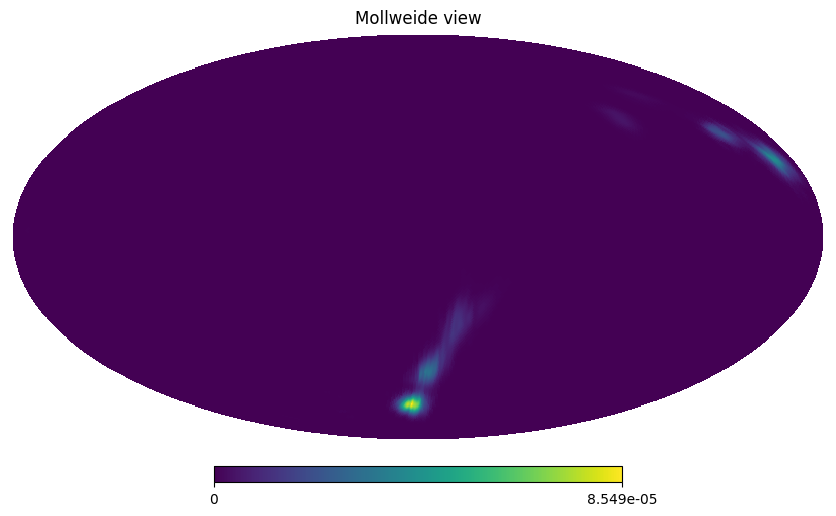

In [4]:
hp.mollview(prob)

What actually is stored in `prob`?

In [6]:
prob

array([2.44158423e-158, 2.37052102e-144, 1.53702316e-109, ...,
       7.51682396e-019, 9.96952265e-020, 7.63384986e-017],
      shape=(3145728,))

It's a one-dimensional array! Yet it represents in 2D image. How does that work? HEALPix is a way to *index* equal-area regions on the unit sphere using integers.

To decode HEALPix indices, you need to know the resolution of the map, which is described by a parameter called `nside`. `nside` is the number of subdivisions of 12 base HEALPix tiles, so the relation between the length of a HEALPix array, `npix`, and its resolution, `nside`, is

$$
    \mathsf{npix} = 12 \cdot \mathsf{nside}^2.
$$

The functions `hp.npix2nside` and `hp.nside2npix` convert between length and resolution.

In [7]:
npix = len(prob)
npix

3145728

In [8]:
nside = hp.npix2nside(npix)
nside

512

The function `hp.pix2ang` allow us to convert from (ra, dec) and HEALPix pixel index.

*Note*: by default, these functions return 'physics' spherical coordinates $(\theta, \phi)$ in radians, but you can switch to 'astronomy' spherical coordinates in degrees by passing the keyword argument `lonlat=True`.

Let's look up the right ascension and declination of pixel 123.

In [9]:
ipix = 123
ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
ra, dec

(np.float64(129.375), np.float64(89.2690292915739))

The function `hp.ang2pix` does the opposite. Let's find the pixel that contains the point RA=194.95, Dec=27.98.

In [10]:
ra = 194.95
dec = 27.98
hp.ang2pix(nside, ra, dec, lonlat=True)

np.int64(833621)

What is the most probable sky location? Just find the pixel with the maximum value, and then find its right ascension and declination.

In [11]:
ipix_max = np.argmax(prob)
ipix_max

np.int64(3012098)

In [12]:
hp.pix2ang(nside, ipix_max, lonlat=True)

(np.float64(5.058139534883721), np.float64(-66.256832082898))

# Visualizing the localization region

Consistent with the molleweide projection above, one finds that the peak of the probability distribution is in the southern hemisphere, which happens to be completely outside the visibility range for ZTF (!!)

Given this situation let's focus on the part of the localization that ZTF does see. We'll start by making a plot of the sky localization focussing on the northern lobe, i.e. declination > 0. Of particular interest are the localization contours corresponding to the 50% and 90% localization regions, which we can calculate by asking which areas of the sky accumulate a total of the corresponding probabilities.

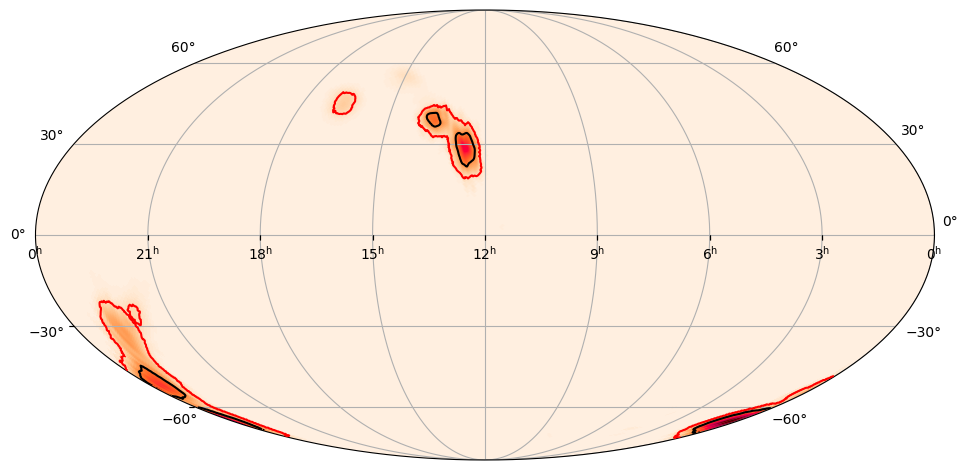

In [16]:
# Sort pixels in descending order of probability
sorted_prob = np.sort(prob[prob > 0])[::-1]
cum_prob = np.cumsum(sorted_prob)

# Find thresholds for 50% and 90% credible regions
p50 = sorted_prob[np.searchsorted(cum_prob, 0.5)]
p90 = sorted_prob[np.searchsorted(cum_prob, 0.9)]

# Get pixels in 90% region
pix_90 = np.where(prob >= p90)[0]

ra_all, dec_all = hp.pix2ang(nside, pix_90, lonlat=True)
north_mask = dec_all > 0
ra_north = ra_all[north_mask]
dec_north = dec_all[north_mask]

# Create mask map for contouring
# Higher probability → lower values in the contour function 
contour_map = np.copy(prob)
contour_map[prob == hp.UNSEEN] = 0 

# Define axes with astro projection (LSST plotting tools)
fig = plt.figure(figsize=(10, 5))

ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection='astro mollweide')
# Plot contours: 50% and 90% credible regions
ax.contour_hpx(contour_map, levels=[p90, p50], colors=['red', 'black'], linewidths=1.5)

from astropy.coordinates import SkyCoord
import matplotlib.patches as mpatches
from astropy import units as u
    
# Plot the HEALPix FITS map
ax.imshow_hpx(filename, cmap="cylon")
ax.grid()
plt.show()

This plot shows that the localization region is confined to a blob centered aroud RA of 13 h and Dec +30 degrees. In many real-life applications, alert "brokers" are setup to filter alerts with healpix partitioning of maps like the one above. However, we are interested in demonstrating the application of such maps, and will simplify the process by looking for alerts within a circular localization region centered on the blob.

First, we will approximate a circular region that roughly encompasses about 80% of the probability region.

In [26]:
p80 = sorted_prob[np.searchsorted(cum_prob, 0.8)]

pix_80 = np.where(prob >= p80)[0]
ra_all_80, dec_all_80 = hp.pix2ang(nside, pix_80, lonlat=True)

# Filter to northern hemisphere
north_mask = dec_all_80 > 0
ra_north_80 = ra_all_80[north_mask]
dec_north_80 = dec_all_80[north_mask]

# Create the SkyCoord array for the northern 90
coords = SkyCoord(ra=ra_north_80 * u.deg, dec=dec_north_80 * u.deg, frame='icrs')

# Convert to Cartesian unit vectors to compute an approximate mean
cart = coords.cartesian
mean_cart = cart.mean()
center = SkyCoord(mean_cart, frame=coords.frame)
print('Central sky coordinates', center)

separations = coords.separation(center)
max_radius = separations.max().to(u.degree).value
print(f"Max separation (80% region): {max_radius:.1f} degrees")

Central sky coordinates <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, )
    (193.17336092, 32.11319451, 0.98884984)>
Max separation (80% region): 15.7 degrees


Our calculation shows that the edges of the 80% localization region are roughly 16 degrees in radius from the approximate central localization position. Lets see what that looks like on the sky projection

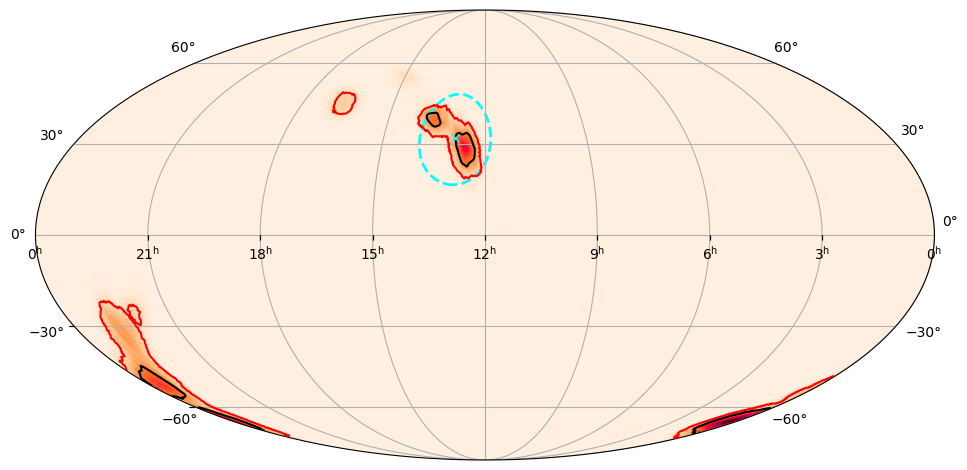

In [30]:
# Define axes with astro projection (LSST plotting tools)
fig = plt.figure(figsize=(10, 5))

ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection='astro mollweide')
# Plot contours: 50% and 90% credible regions
ax.contour_hpx(contour_map, levels=[p90, p50], colors=['red', 'black'], linewidths=1.5)

from astropy.coordinates import SkyCoord
import matplotlib.patches as mpatches
from astropy import units as u

# Draw query region as a large transparent circle
query_circle = mpatches.Circle(
    (center.ra.degree, center.dec.degree),
    radius=max_radius,
    transform=ax.get_transform('world'),
    facecolor='none',
    edgecolor='cyan',
    linewidth=2,
    linestyle='--',
    label=f'Radial Cone ({max_radius:.0f}" radius)'
)

ax.add_patch(query_circle)
ax.plot(
    center.ra.degree,
    center.dec.degree,
    transform=ax.get_transform('world'),
    marker='x',
    color='cyan',
    markersize=6,
    label='Radial Center'
)
    
# Plot the HEALPix FITS map
ax.imshow_hpx(filename, cmap="cylon")
ax.grid()
plt.show()

# Alert filtering using a broker


Not bad for an approximate localization! This greatly simplifies our alert filtering procedure using public alert brokers which provide APIs to filter on cone searches. For this exercise, we will be using the [Alerce](https://alerce.science/) broker, which provides an easy python API to query alerts with spatial and temporal constraints

In [33]:
#this is our alert broker
from alerce.core import Alerce
client = Alerce()

Recall that ZTF produces few 100K alerts every night as part of this default survey. Even though we'll be only looking at public ZTF alerts, we have to be mindful with spatial and temporal constraints to ensure we are not flooded with irrelevant transients.

Going ahead, we can apply three physically motivated constraints on the ZTF alert stream
- We can that the associated transient is catastrophic in nature, i.e. the transient should have been detected for the first time in a short time interval *after* the event and shortly after.
- The transient should be spatially located within our approximated circular localization region
- The transient should be detected in multiple epochs (at least 3) to avoid contamination from moving solar system objects.

**Think: The requirement of 3 detections can be minimized to 2, but how is that related to the ZTF observing strategy?**

In [34]:
# Start by computing the MJD range corresponding to first 5 days after the GW event
start_time = Time('2019-05-21 03:02:29', format='iso', scale='utc').mjd
end_time = Time('2019-05-26 03:02:29', format='iso', scale='utc').mjd

print(f"Start MJD: {start_time}, End MJD: {end_time}")

Start MJD: 58624.12672453704, End MJD: 58629.12672453704


In [37]:
#Lets query Alerce!
df = client.query_objects(
    format='pandas',
    ra=center.ra.degree,
    dec=center.dec.degree,
    radius=max_radius * 3600,  # in arcsec
    firstmjd=[start_time, end_time],
    page_size=10000,
    ndet = [3, 99999]
)

print(f"Found {len(df)} objects")

Found 110 objects


As you can see, even with these stringent constraints, one ends up with > 100 sources! The optical sky is extremely variable, and that makes these searches all the more challenging! 

Lets take a look at the list of objects

In [38]:
print(df)

              oid ndethist  ncovhist  mjdstarthist    mjdendhist  corrected  \
0    ZTF19aavlxpn      112      1911  58511.500000  60059.250000       True   
1    ZTF19aavktnq       29       542  58628.187755  58642.235613      False   
2    ZTF19aaseyah      242      1882  58494.500000  60080.250000       True   
3    ZTF19aayehfu        5       740  58246.232118  58645.212535      False   
4    ZTF19aavldrt       16       209  58628.210266  58663.195266      False   
..            ...      ...       ...           ...           ...        ...   
105  ZTF19aavrqdg       23      3697  58628.194005  60644.514236       True   
106  ZTF18aaiahjr      396      2533  58202.353160  60743.448935       True   
107  ZTF19aasresd      219      2377  58467.546979  60649.529479       True   
108  ZTF19aaseyhp       29      2458  58486.554468  60814.300868       True   
109  ZTF19aayeheo      918      2400  58280.206053  60859.226863       True   

     stellar  ndet   g_r_max  g_r_max_corr  ...    

We see that some of the objects returned have mjdstarthist before the event! Why is that?

It turns out that the public ZTF alert stream was initiated in mid-2018, which represents the start of operations of the alert brokers. However, ZTF did collect commissioning on-sky data prior to this date, which an create some prior alerts missing in the public archive but still correctly accounted in the ZTF alert schema.

It is straightforward to remove these alerts by filtering on the pandas table directly. In addition, we don't want to be detecting variable stars, and we'll use the Alerce-issued "stellar" parameter to remove likely variable stars.

In [45]:
df_filtered = df[(df["mjdstarthist"] > start_time) & (df["mjdstarthist"] < end_time) & (df["stellar"] == False)]
print(len(df_filtered))

24


# Vetting of possible candidates

Okay, we are down to <25 objects from > 1M alerts issued during this time period! At this stage, it is often useful to visually vet the light curves and cutouts for the objects. Remember that since we are working with an archival event, we have the LUXURY (in caps!) of knowing what these transients did over its lifetime. In real searches, one is only looking at the first few days of evolution, making it remarkably challenging!

We'll define some functions to parse the Alerce light curve results and plot light curves and postage stamps

In [42]:
# Color config for filters
colors = {1: "green", 2: "red"}
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}
sizes = {1: 30, 2: 60}

def plotStamps(oid, lc_det, client):
    # Find first detection with a valid stamp
    if "has_stamp" not in lc_det.columns or lc_det["has_stamp"].sum() == 0:
        print(f"⚠️ No stamp available for {oid}")
        return

    try:
        candid = lc_det.loc[lc_det.has_stamp].sort_values("mjd").candid.iloc[0]
        stamps = client.get_stamps(oid, candid, format='HDUList')
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
    except Exception as e:
        print(f"❌ Failed to fetch stamps for {oid}: {e}")
        return

    # Plot the cutouts
    fig, ax = plt.subplots(ncols=3, figsize=(12, 5))
    titles = ["Science", "Reference", "Difference"]
    images = [science, ref, difference]

    for i in range(3):
        img = np.log1p(images[i])  # log scale with log1p for stability
        ax[i].imshow(img, cmap='viridis', origin='lower')
        ax[i].set_title(titles[i])
        ax[i].axis("off")

    ax[0].set_title(f"{oid}, candid: {candid}", loc='left', fontsize=14)
    plt.tight_layout()
    plt.show()

def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            ax.errorbar(
                SN_det[mask].mjd, SN_det[mask].magpsf,
                yerr=SN_det[mask].sigmapsf,
                c=colors[fid], label=labels[fid],
                marker=markers[fid], linestyle='none'
            )

        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:
            ax.scatter(
                SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim,
                c=colors[fid], alpha=0.5, marker='v',
                label=f"lim.mag. {labels[fid]}", s=sizes[fid]
            )

    # Add vertical marker at trigger time
    mjd_marker = Time('2019-05-21 03:02:29', format='iso', scale='utc').mjd
    ax.axvline(
        mjd_marker, color='black', linestyle='--',
        linewidth=1.5, label='Trigger Time (2019-05-21)'
    )

    ax.set_title(oid, fontsize=20)
    ax.set_xlabel("MJD", fontsize=16)
    ax.set_ylabel("Apparent magnitude", fontsize=16)
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def getSNdata(oid, doLC=False, doStamps=False):
    results = {"oid": oid}

    try:
        lc_det = client.query_detections(oid, format='pandas').sort_values("mjd")
        results["lc_det"] = lc_det
    except Exception as e:
        print(f"⚠️ Could not fetch detections for {oid}: {e}")
        lc_det = pd.DataFrame()

    try:
        lc_nondet = client.query_non_detections(oid, format='pandas').sort_values("mjd")
        results["lc_nondet"] = lc_nondet
    except Exception as e:
        print(f"⚠️ Could not fetch non-detections for {oid}: {e}")
        lc_nondet = pd.DataFrame()

    # Plot light curve
    if doLC and not lc_det.empty and not lc_nondet.empty:
        plotLC(oid, lc_det, lc_nondet)

    # Plot stamps
    if doStamps and not lc_det.empty:
        plotStamps(oid, lc_det, client)

    return results

Now we are ready to start plotting some light curves and postage stamps! For clarity, we are also plotting a line indicating the time of the GW trigger.

📈 Plotting light curve for ZTF19aavktnq


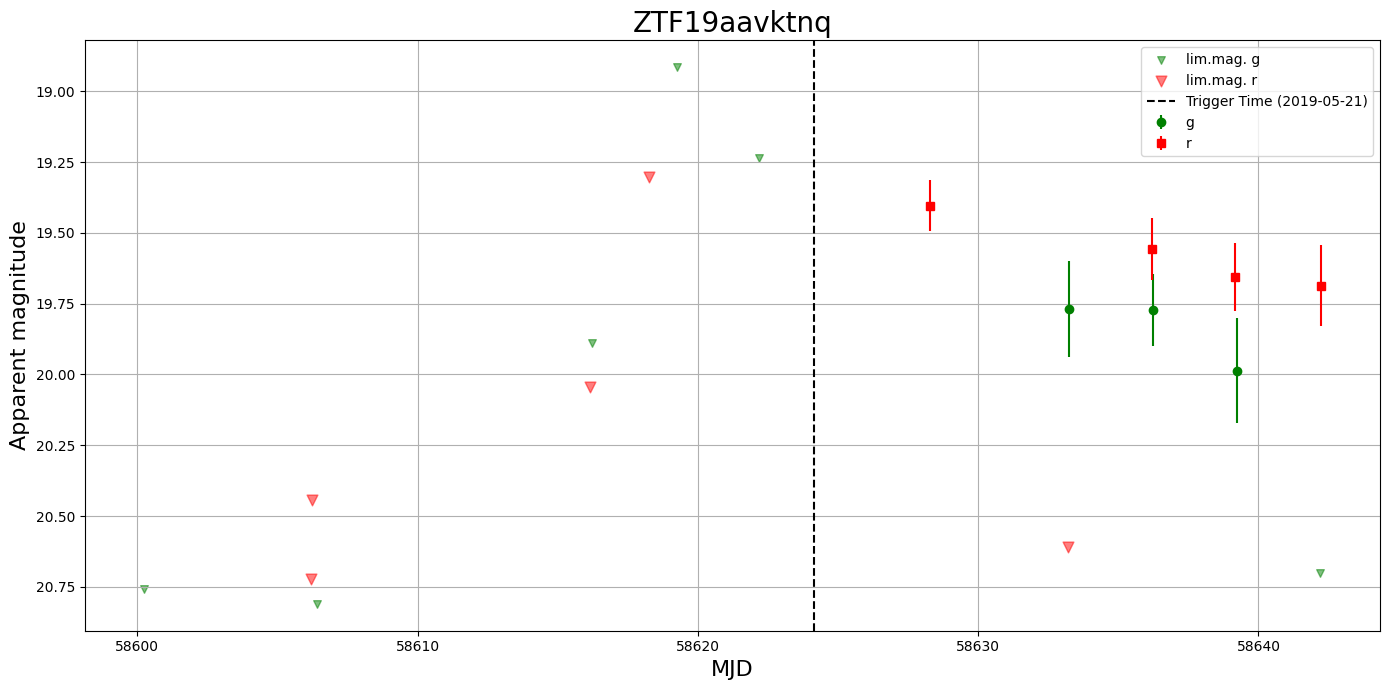

/var/folders/nz/hcm2rh5x19q0p928d8hqzzj00000gn/T/ipykernel_30772/2212437948.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


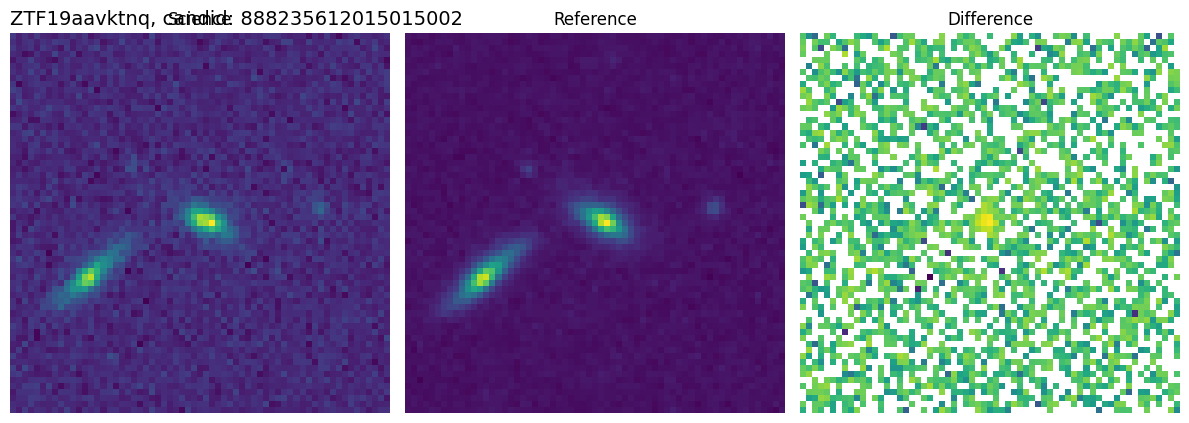

📈 Plotting light curve for ZTF19aavldrt


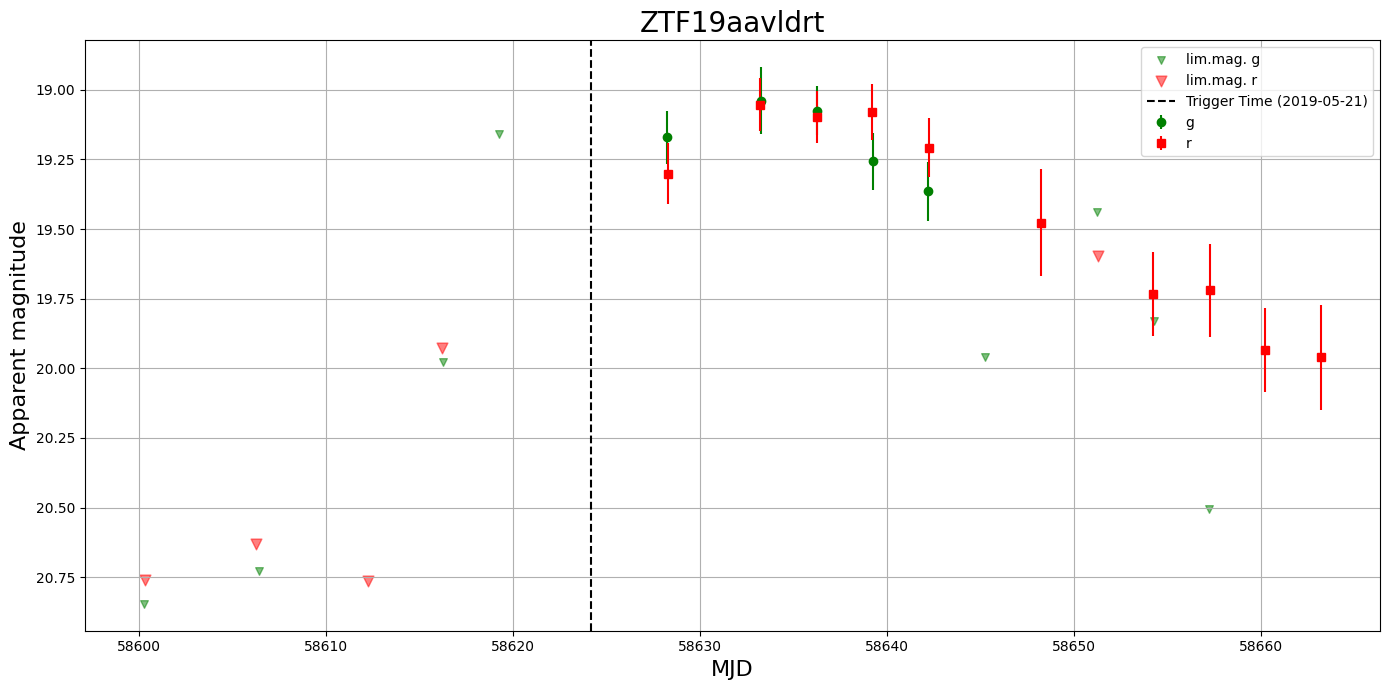

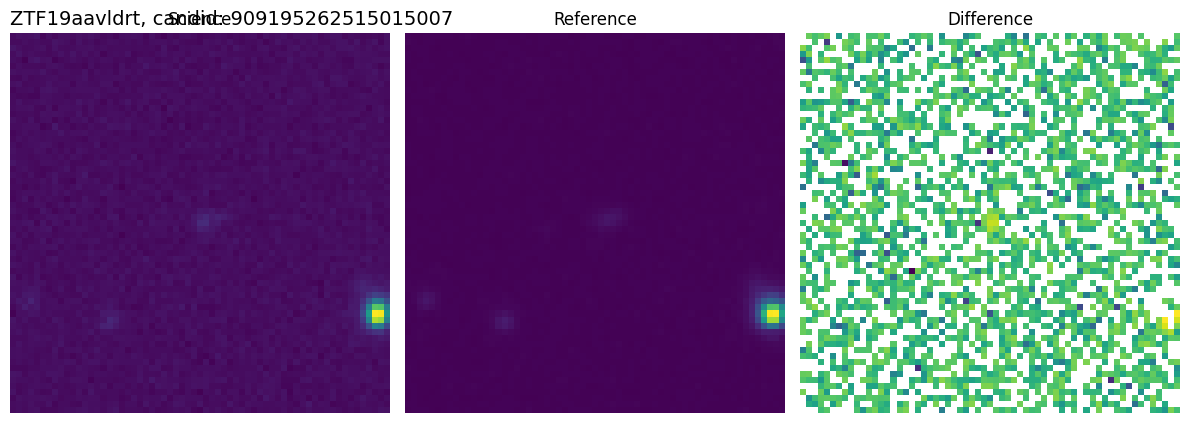

📈 Plotting light curve for ZTF19aavldqp


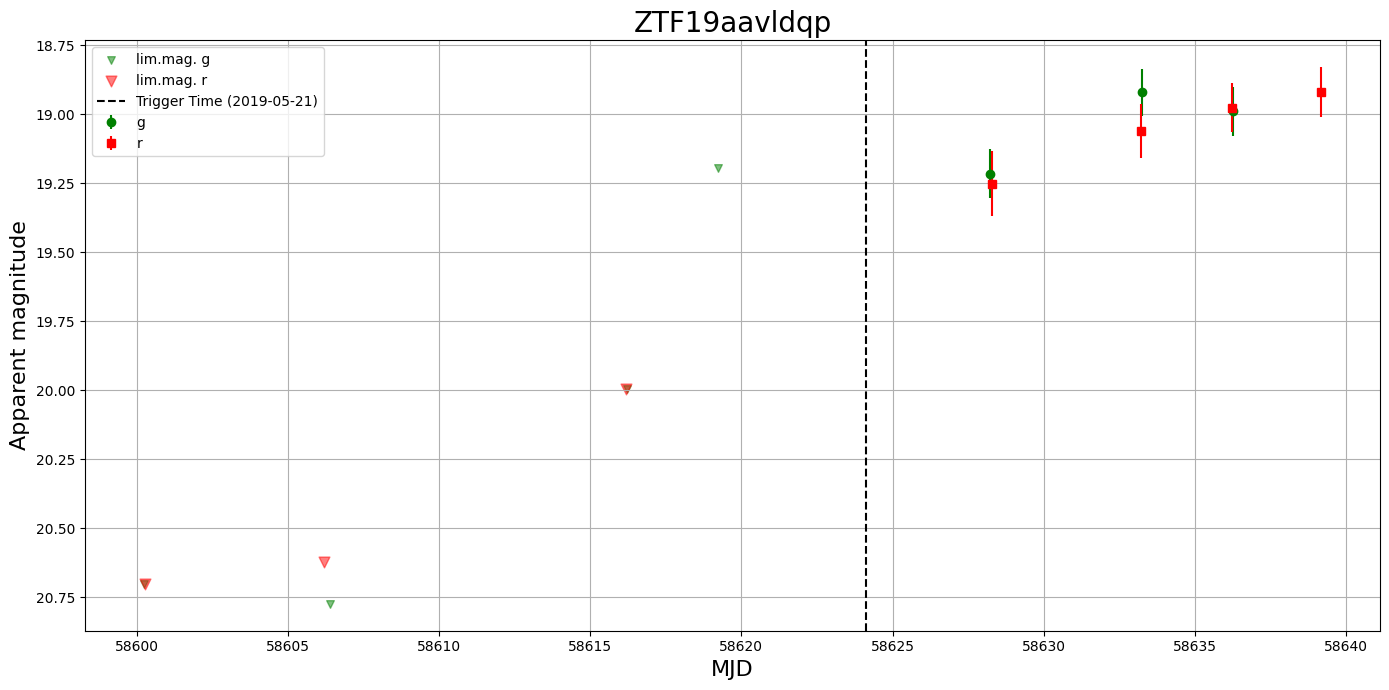

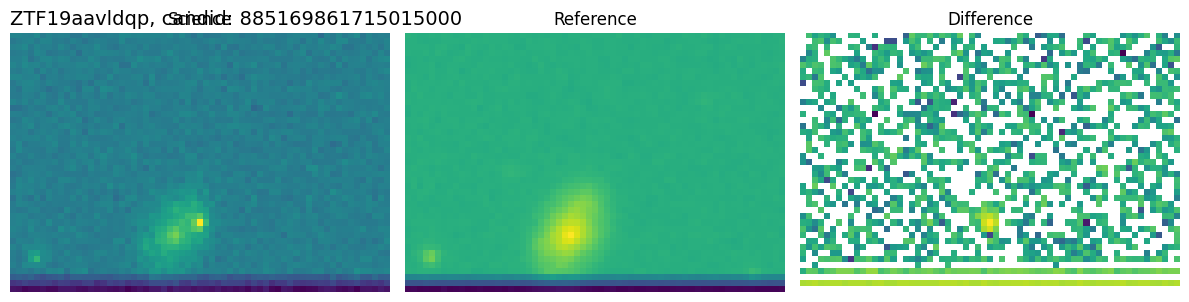

📈 Plotting light curve for ZTF19aavkwuc


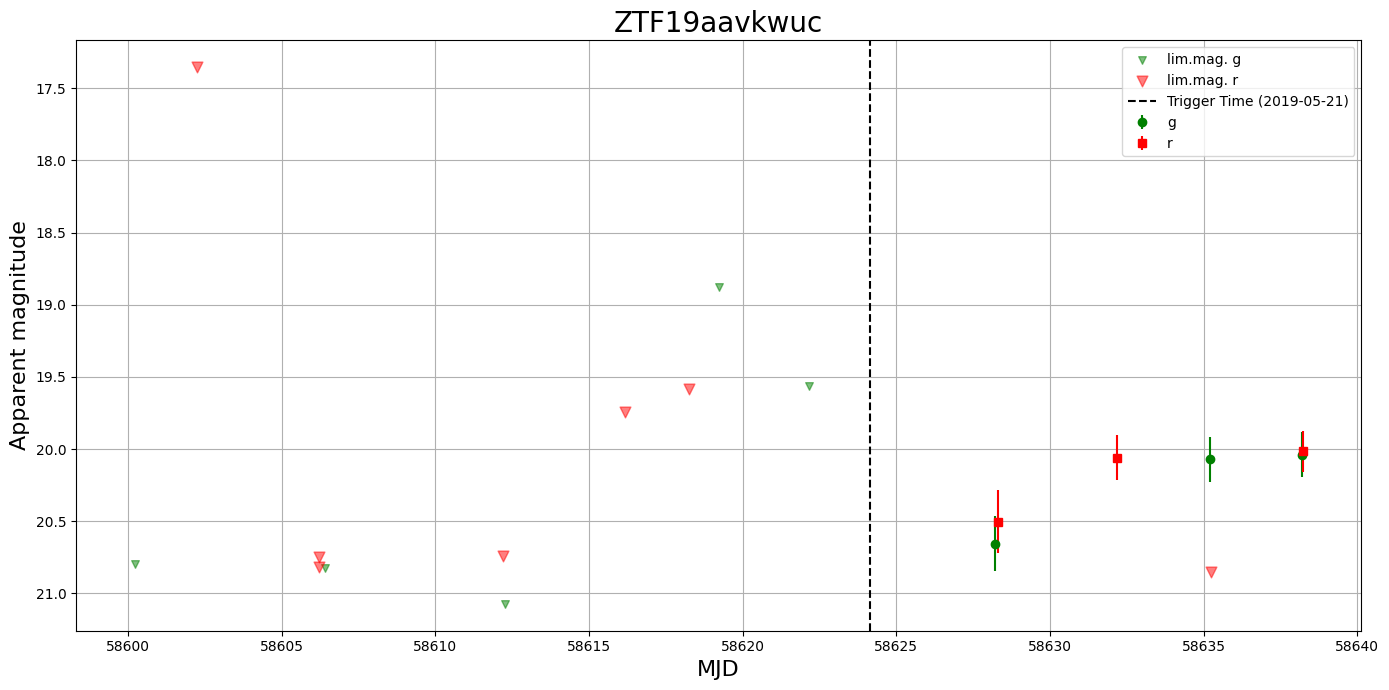

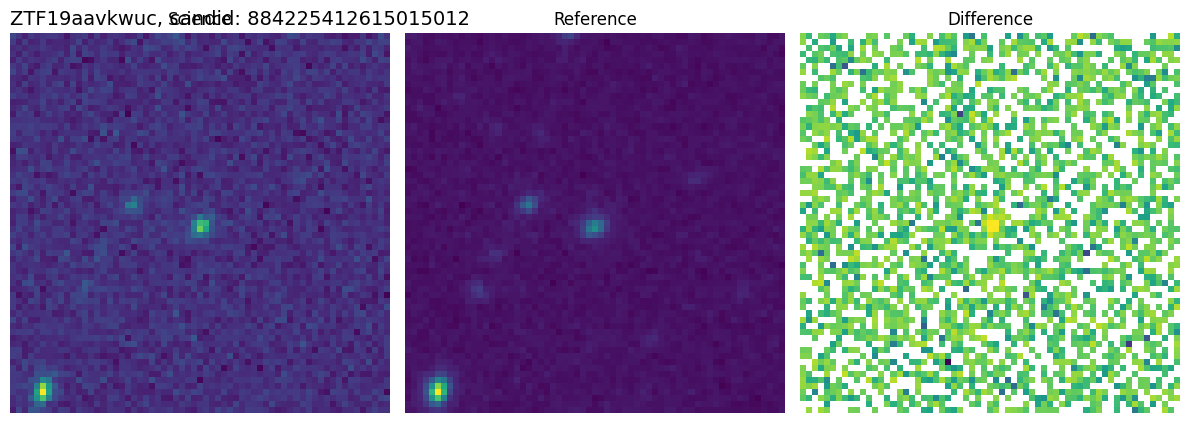

📈 Plotting light curve for ZTF19aavrjeo


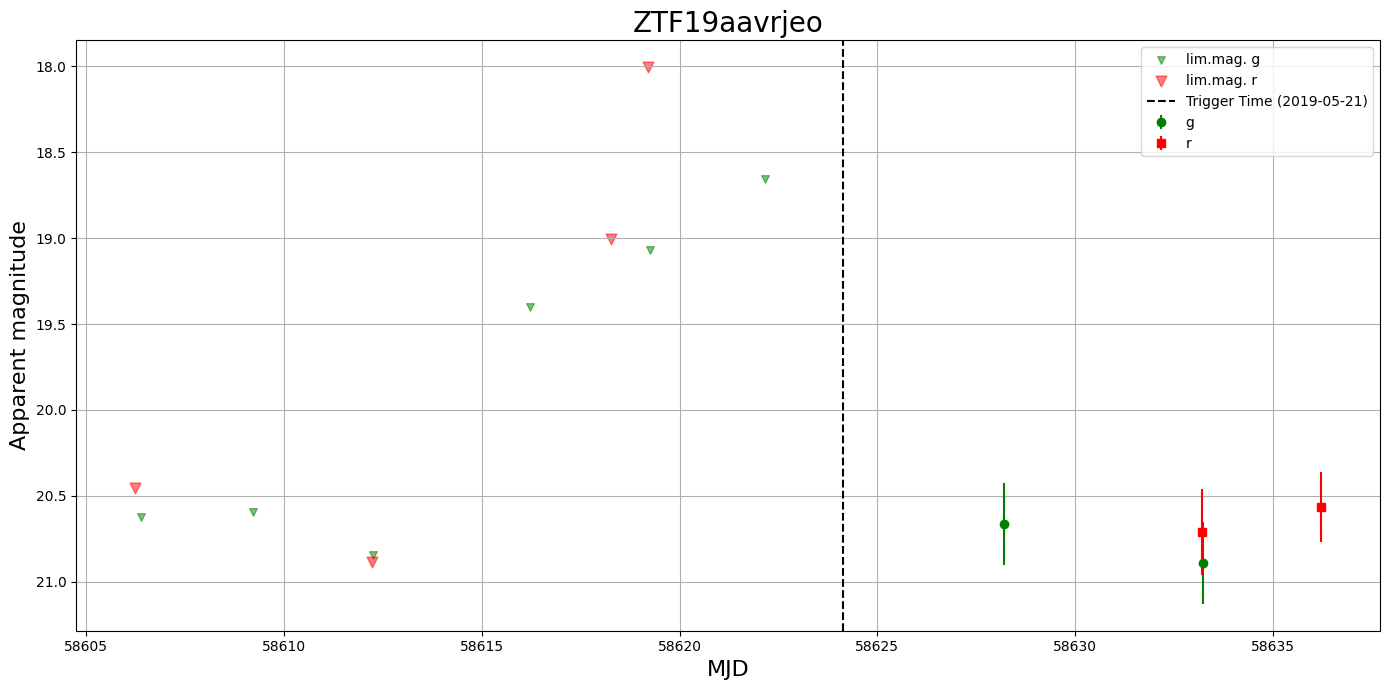

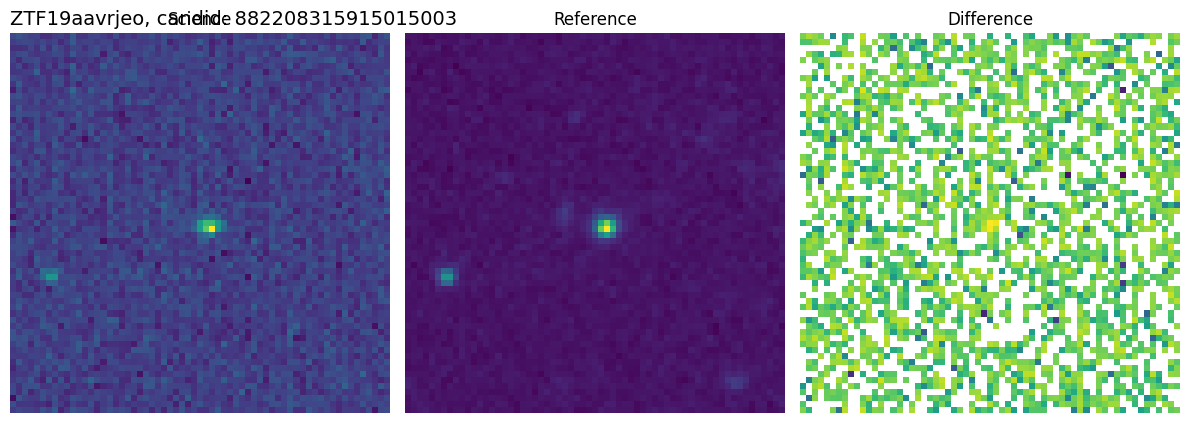

📈 Plotting light curve for ZTF19aavkvtm


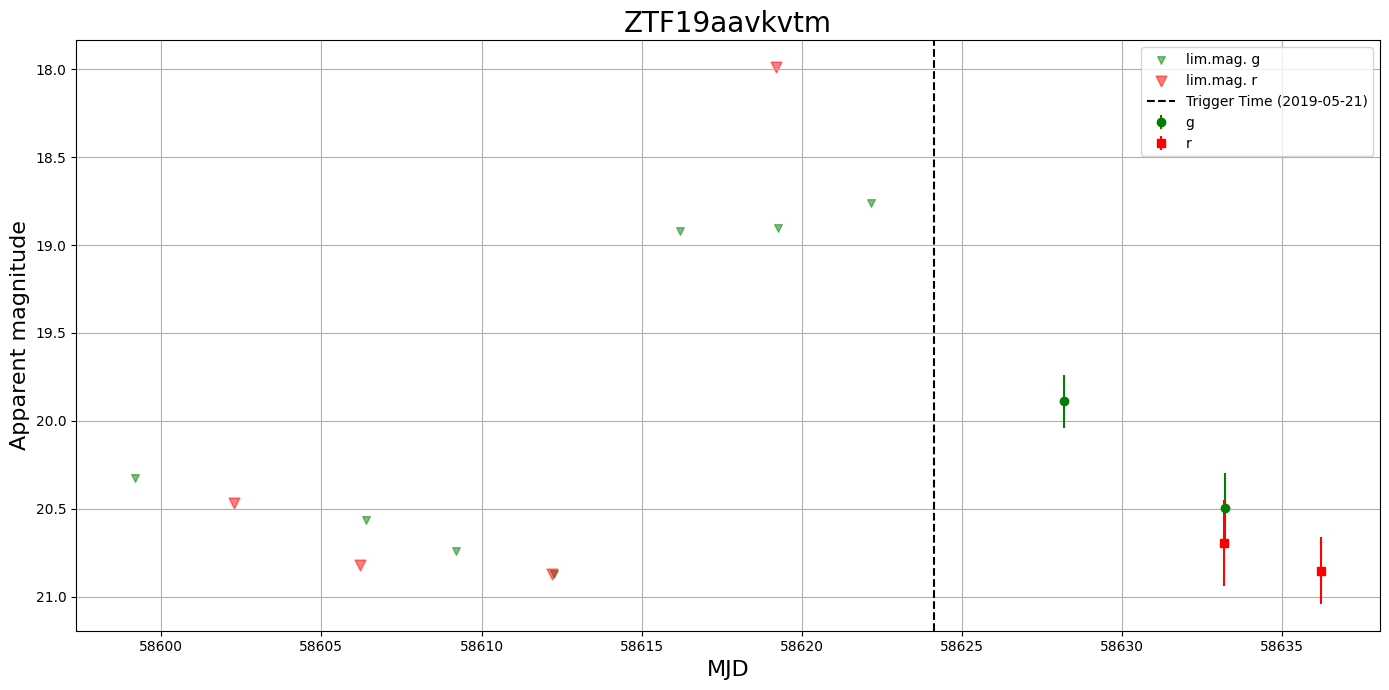

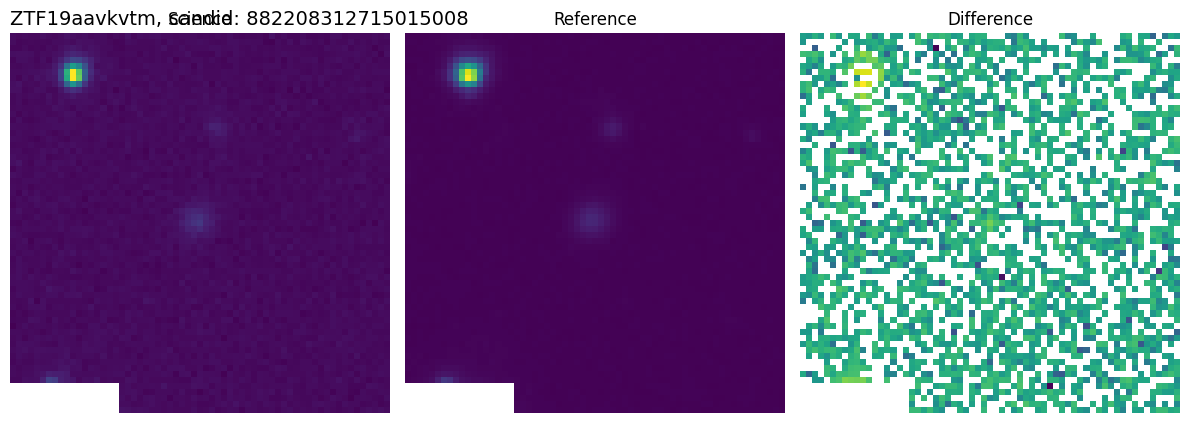

📈 Plotting light curve for ZTF19aavlccs


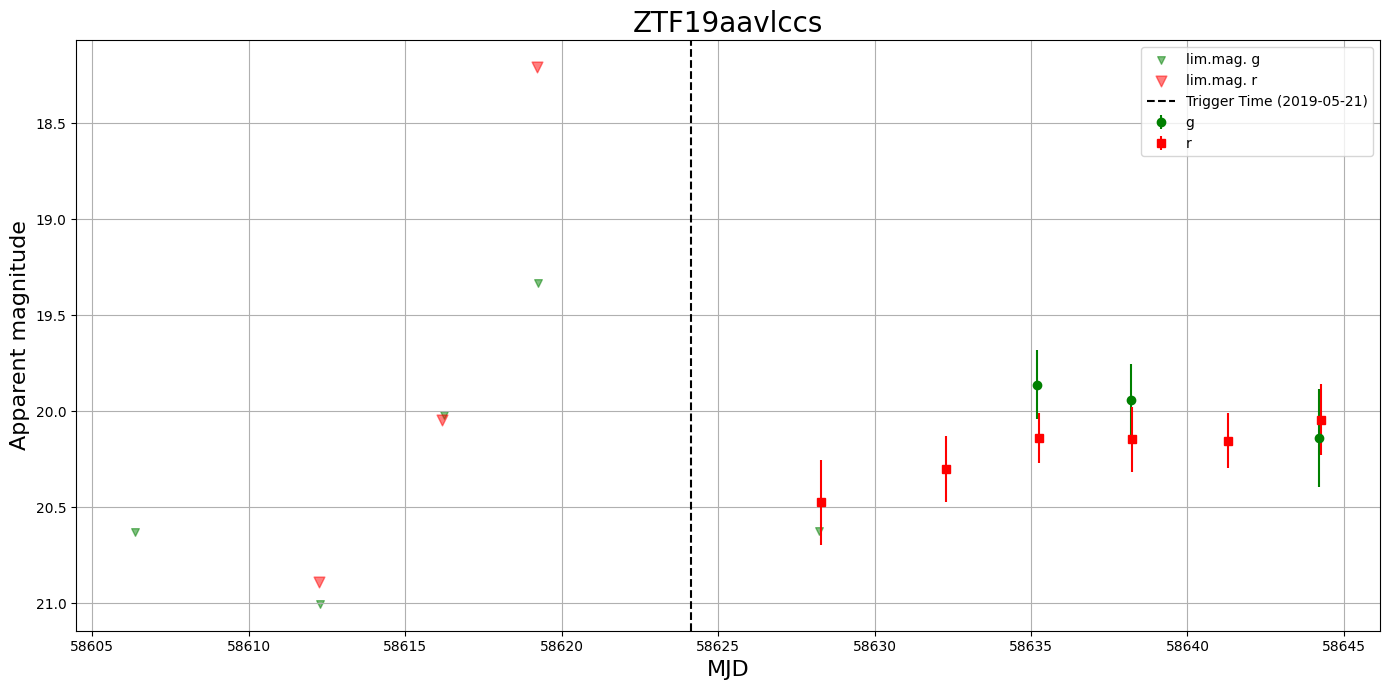

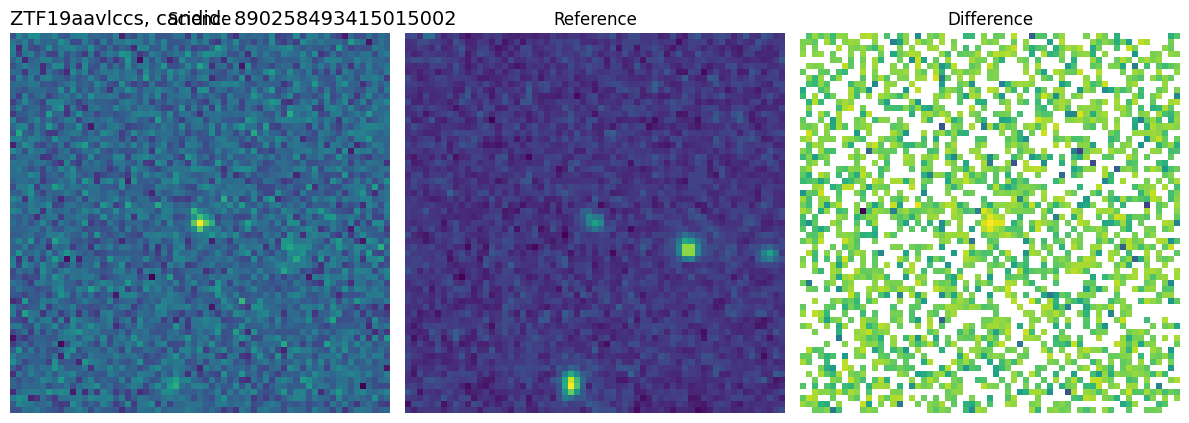

📈 Plotting light curve for ZTF19aawiphn


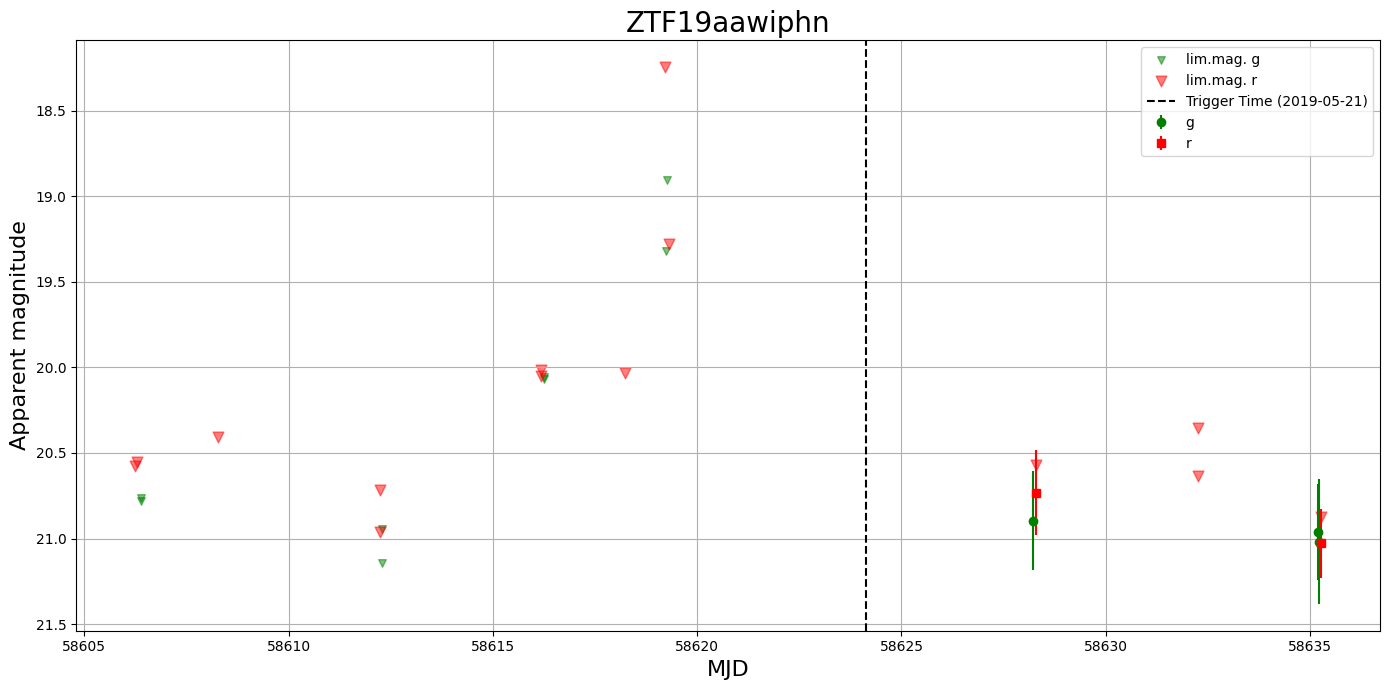

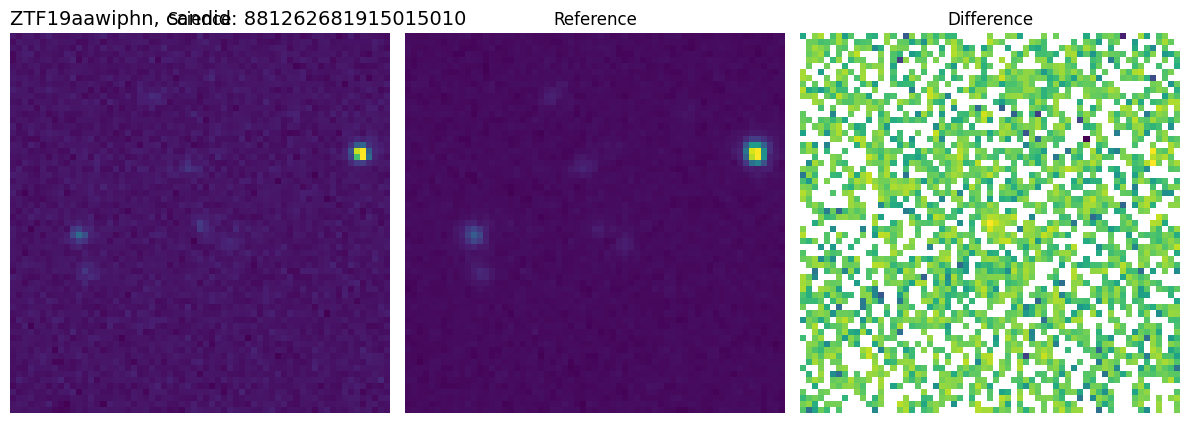

📈 Plotting light curve for ZTF19aavldve


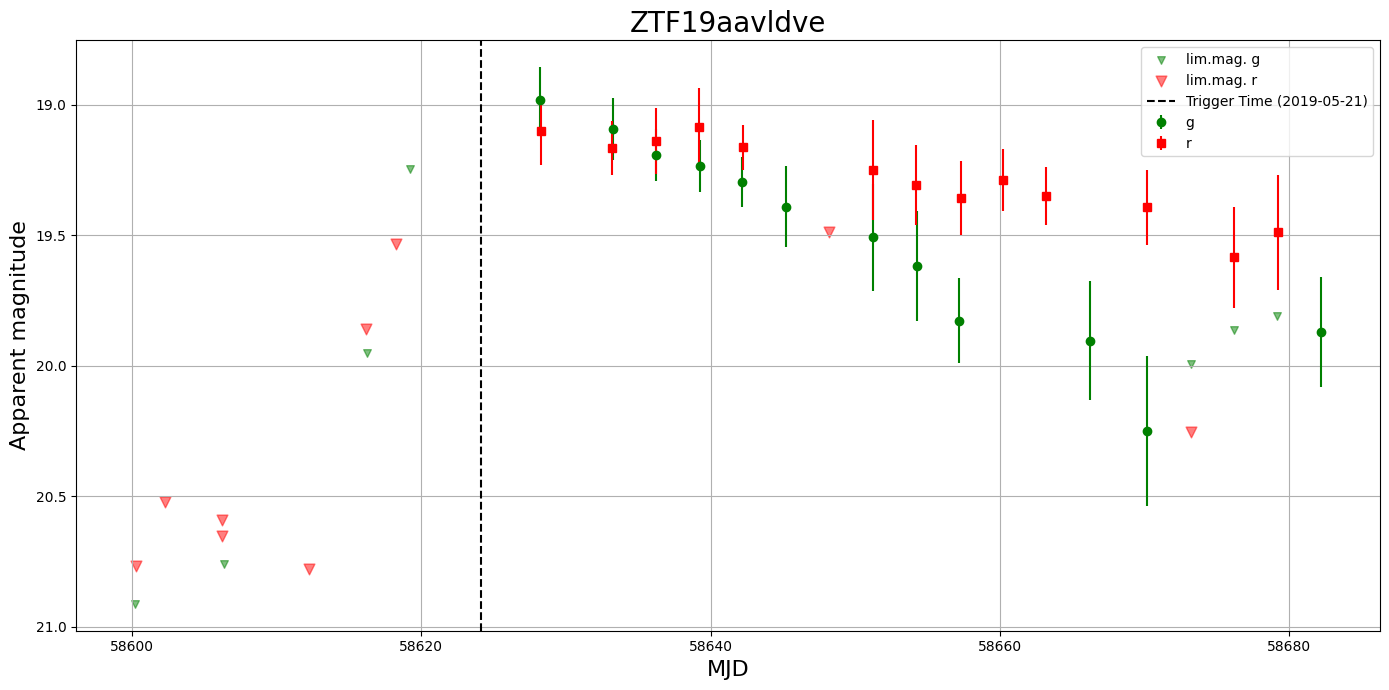

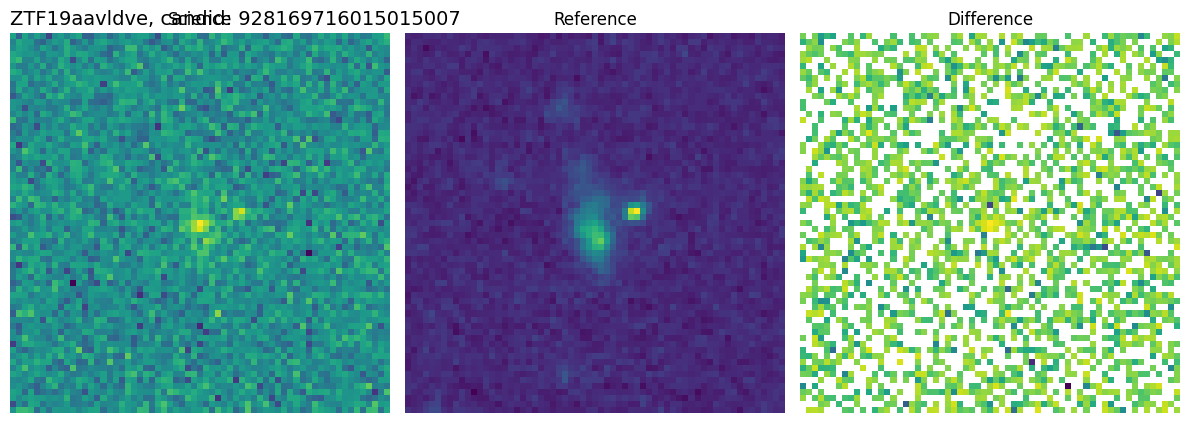

📈 Plotting light curve for ZTF19aavkvri


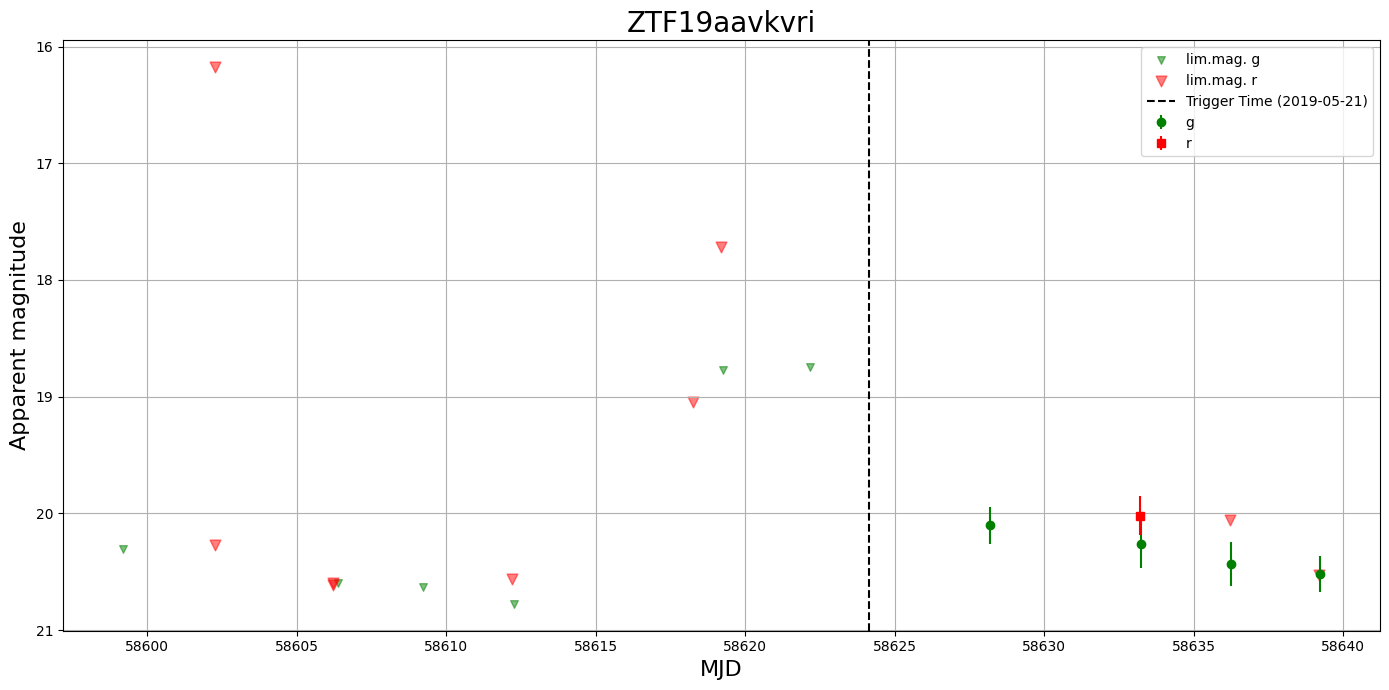

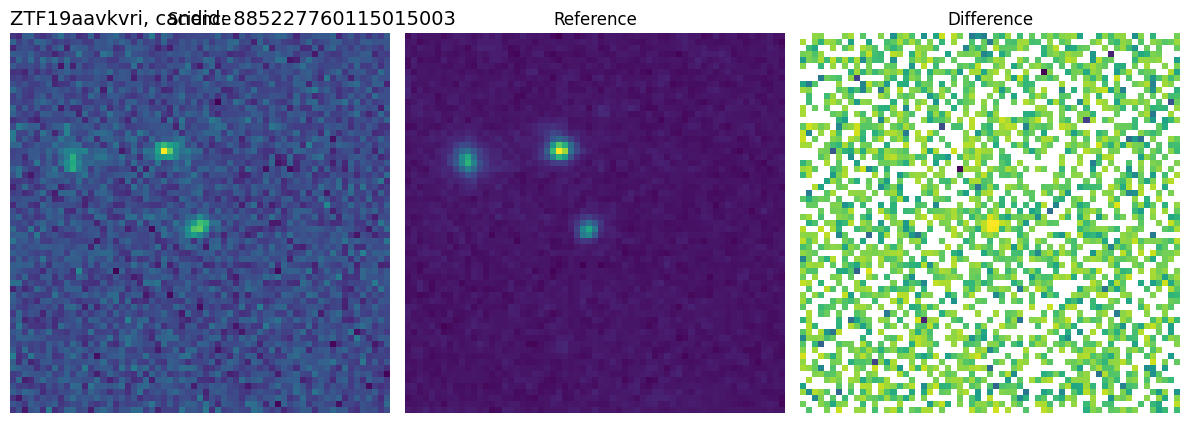

📈 Plotting light curve for ZTF19aavqwej


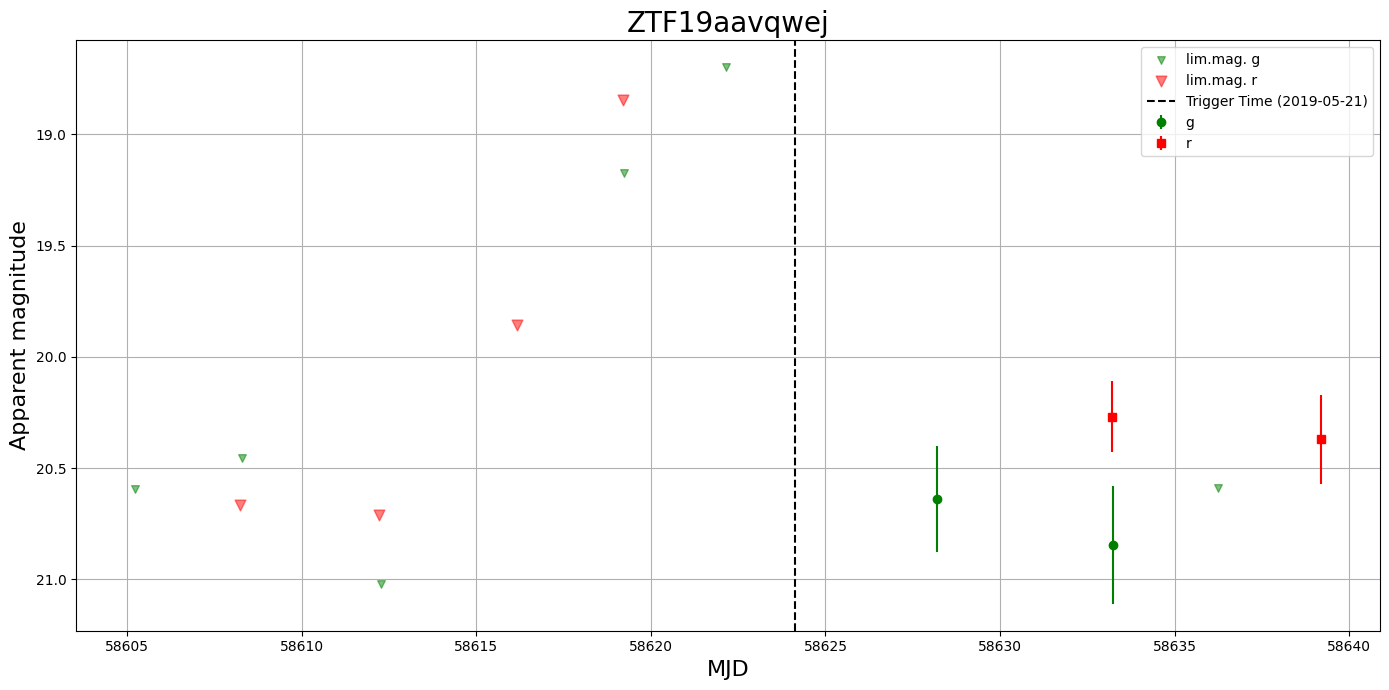

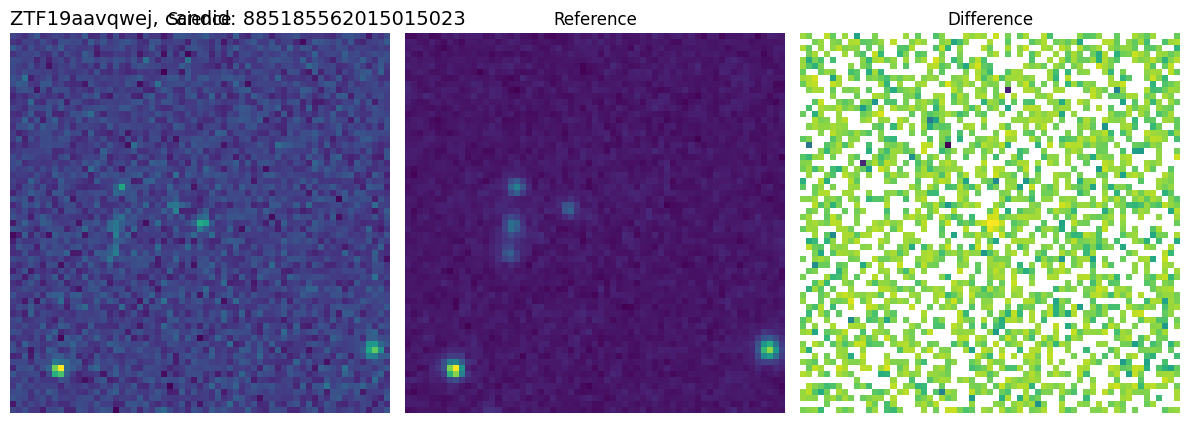

📈 Plotting light curve for ZTF19aavkvky


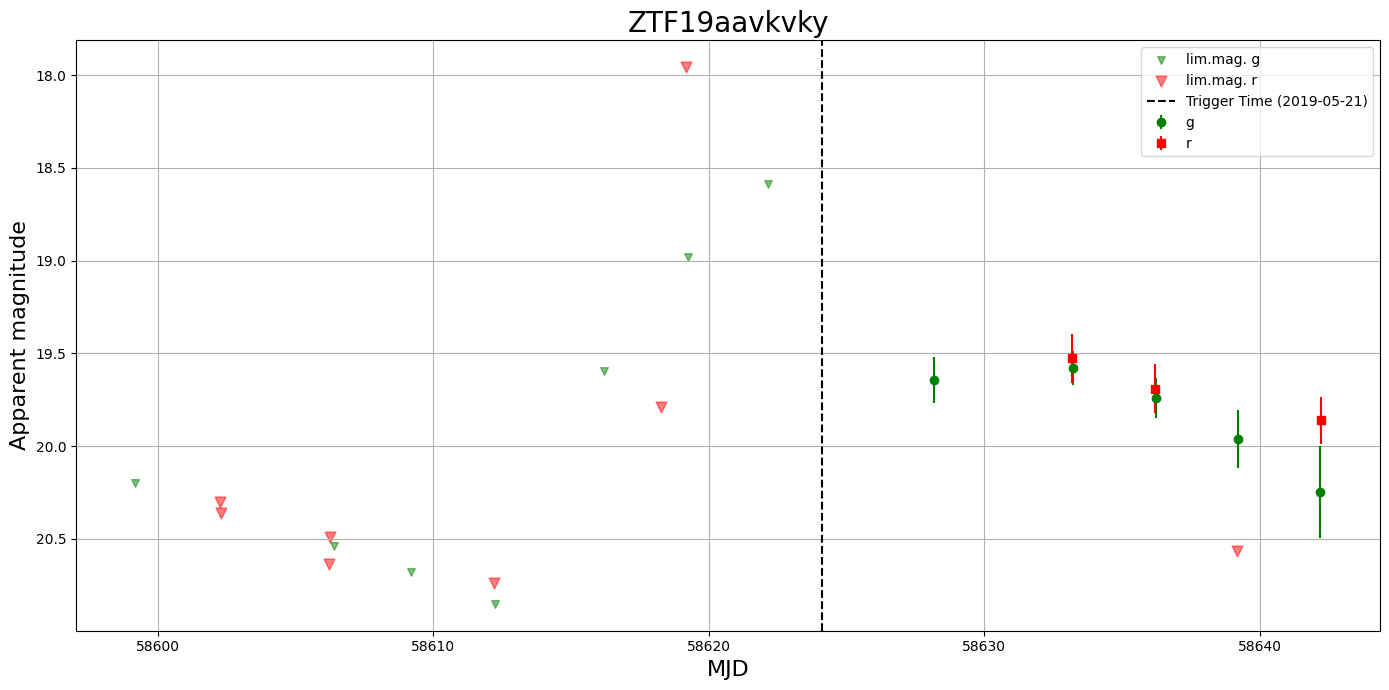

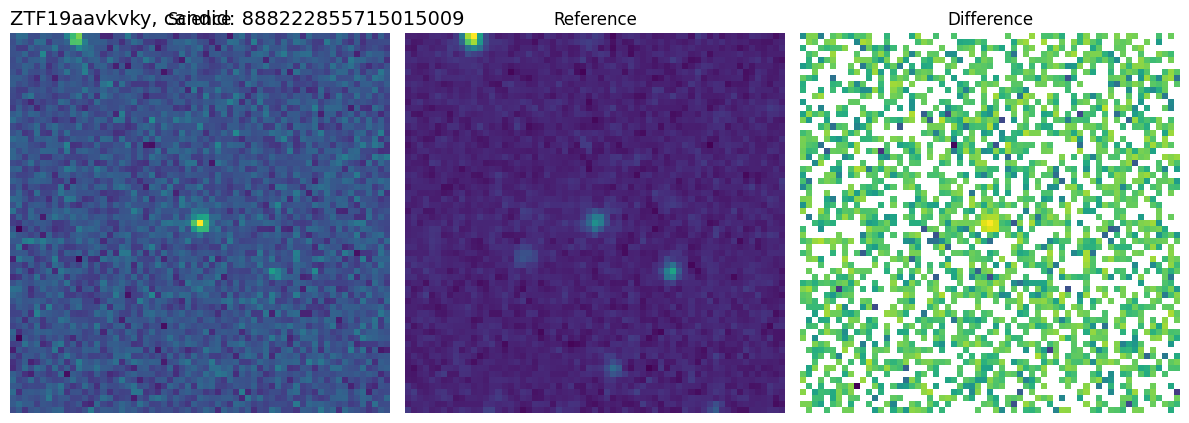

📈 Plotting light curve for ZTF19aavkytt


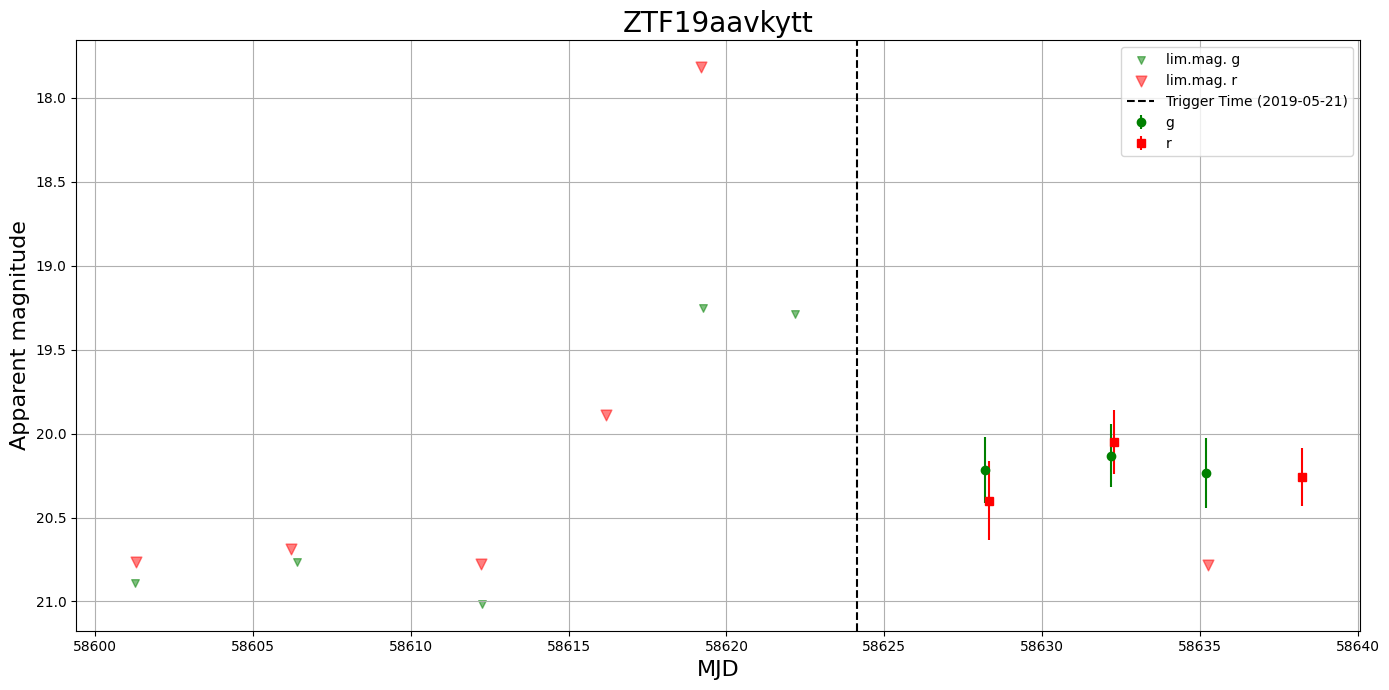

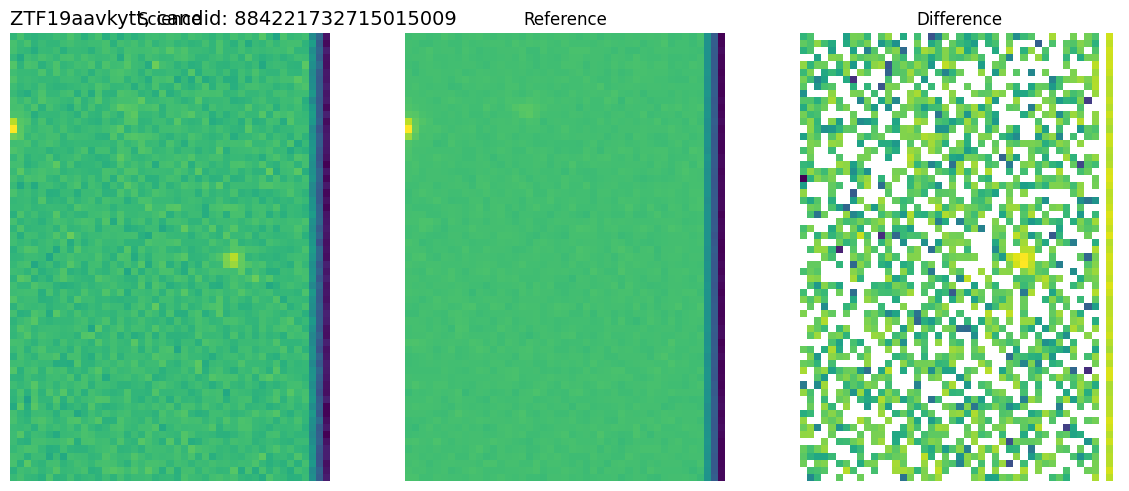

📈 Plotting light curve for ZTF19aavkxfj


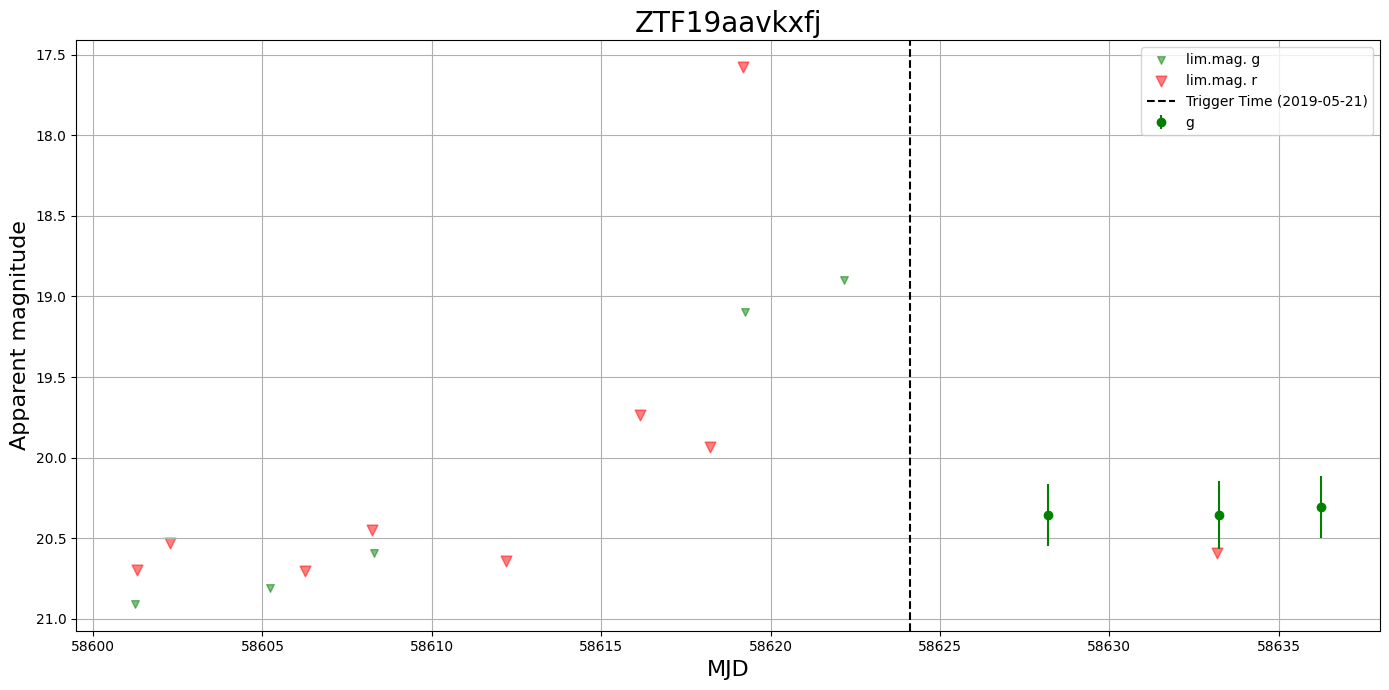

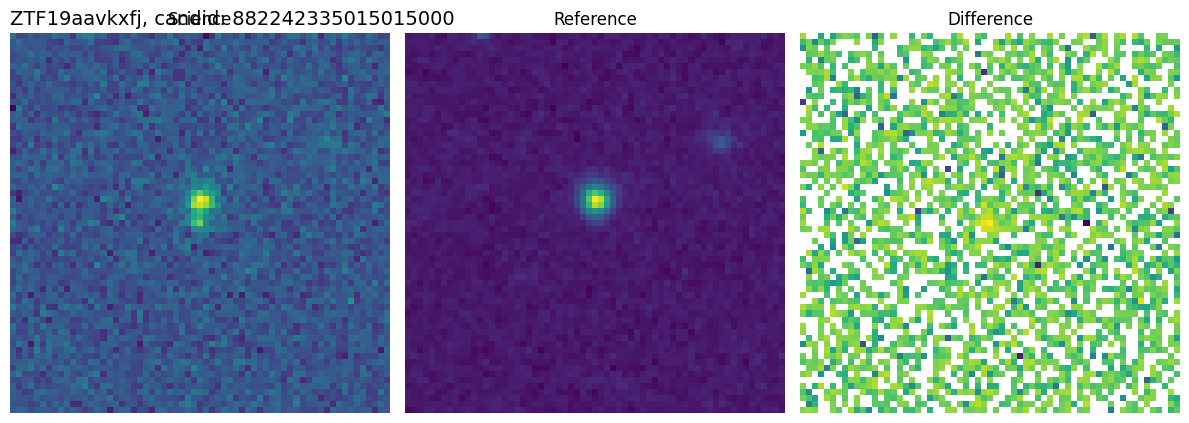

📈 Plotting light curve for ZTF19aavkvpn


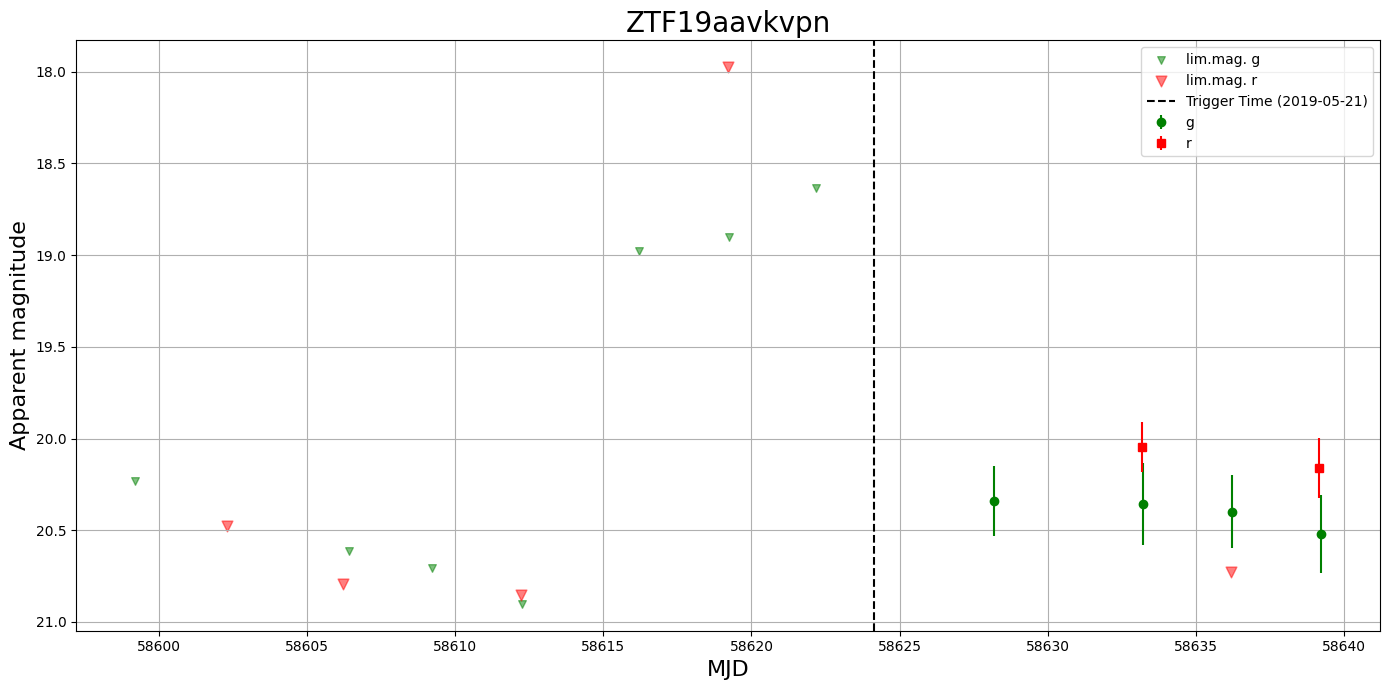

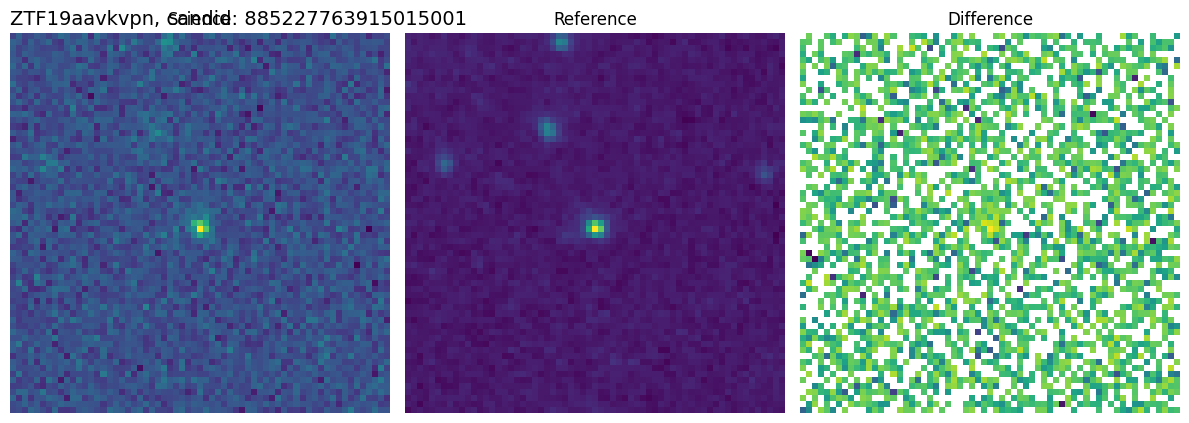

📈 Plotting light curve for ZTF19aavllzj


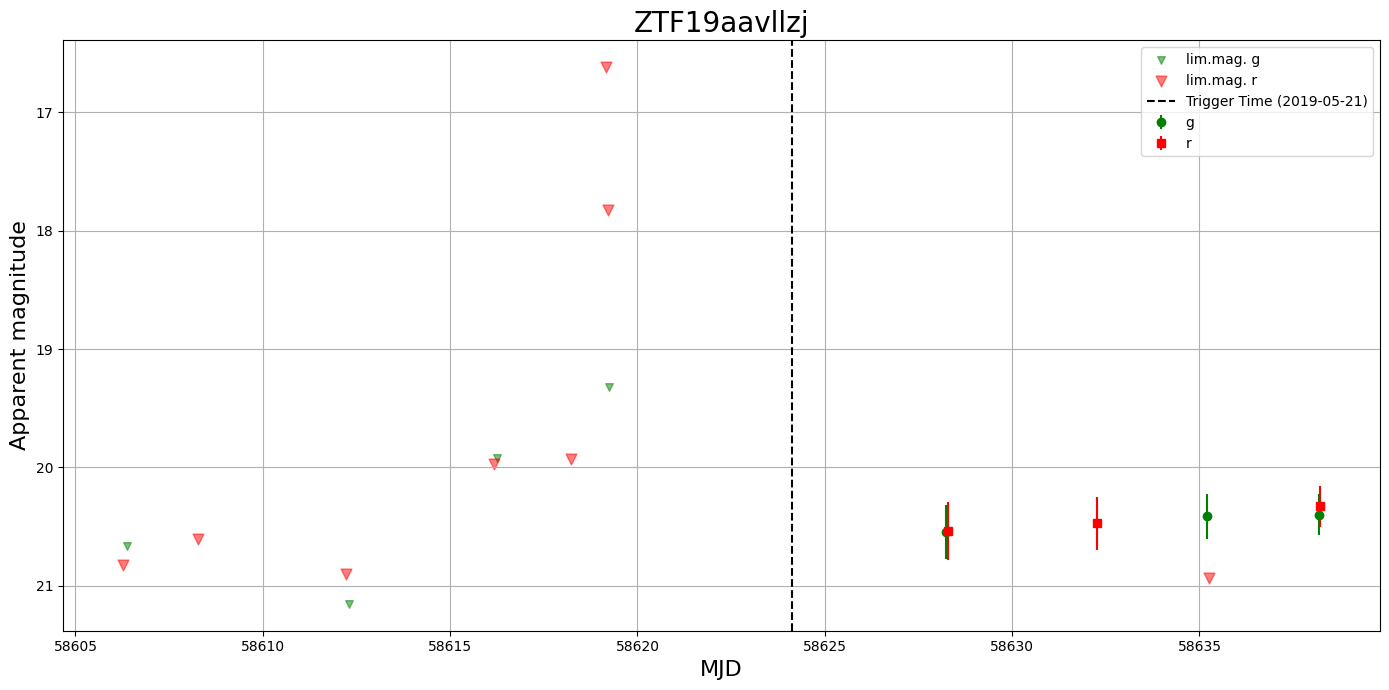

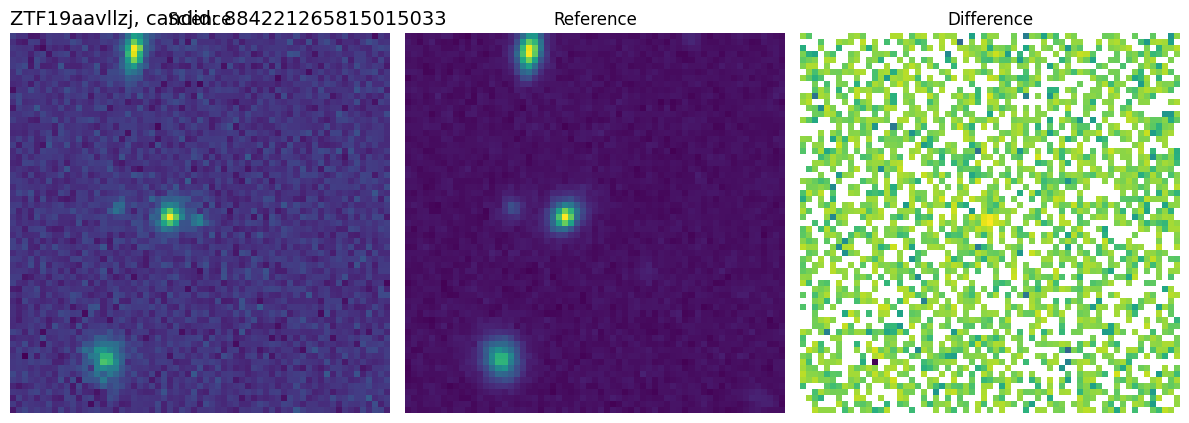

📈 Plotting light curve for ZTF19aavkvvb


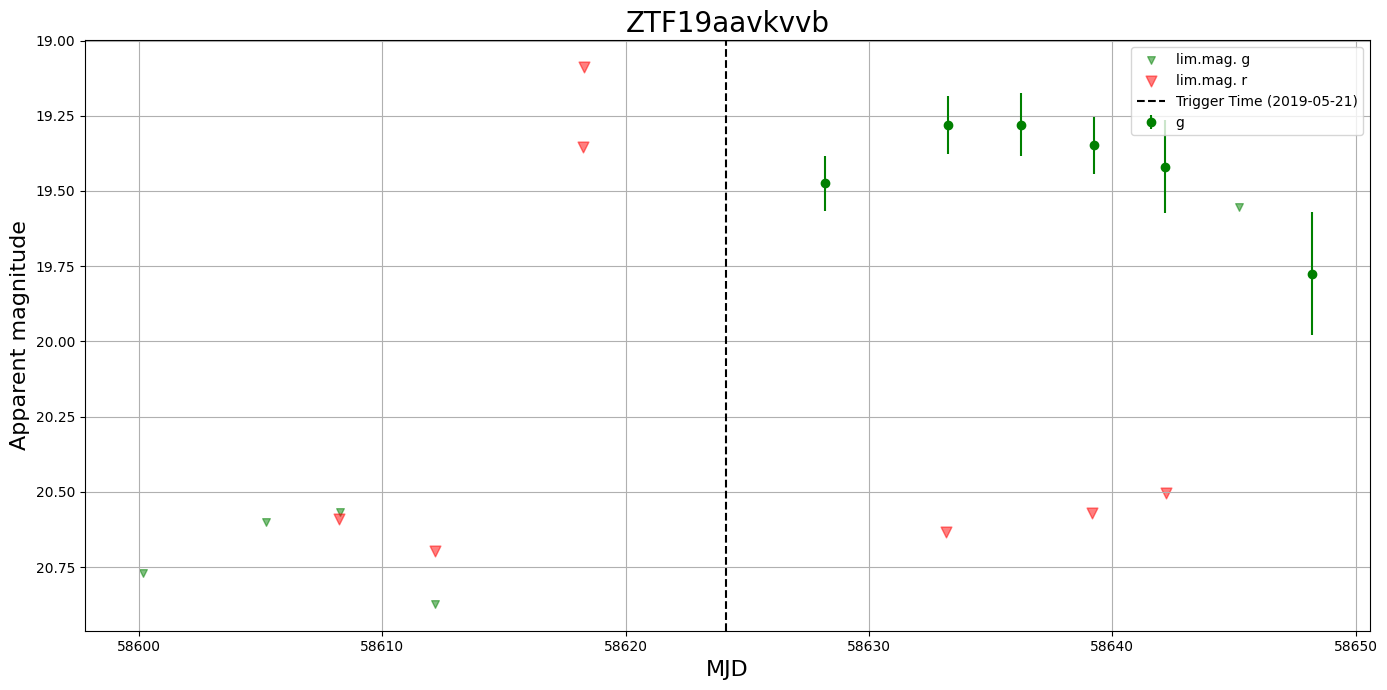

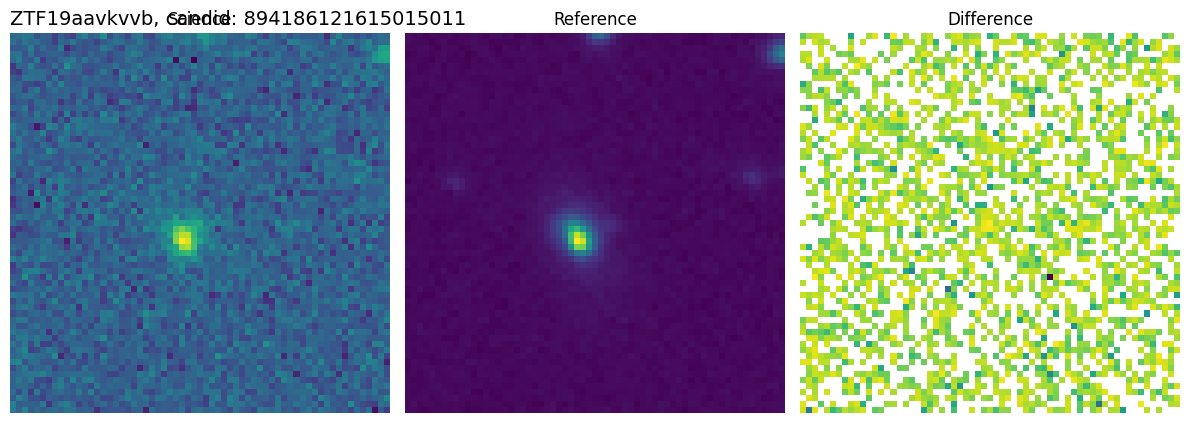

📈 Plotting light curve for ZTF19aavlemq


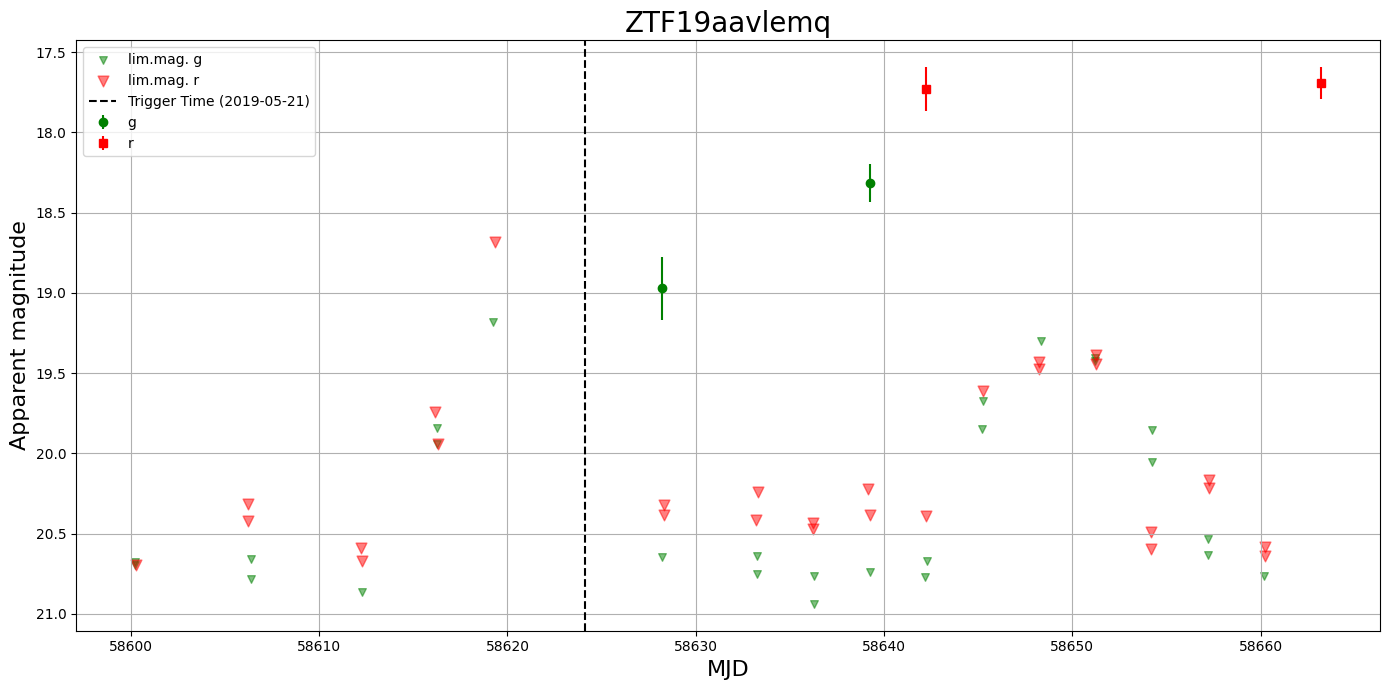

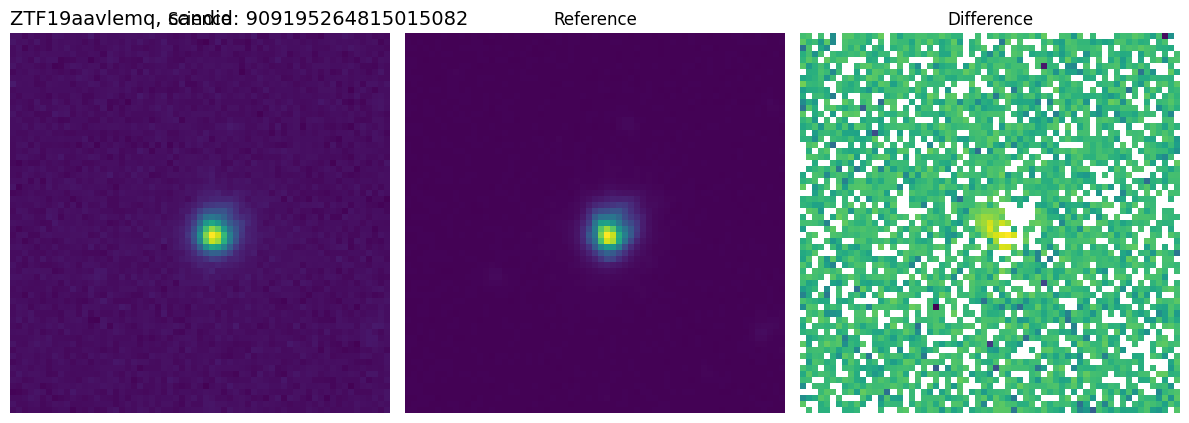

📈 Plotting light curve for ZTF19aavleir


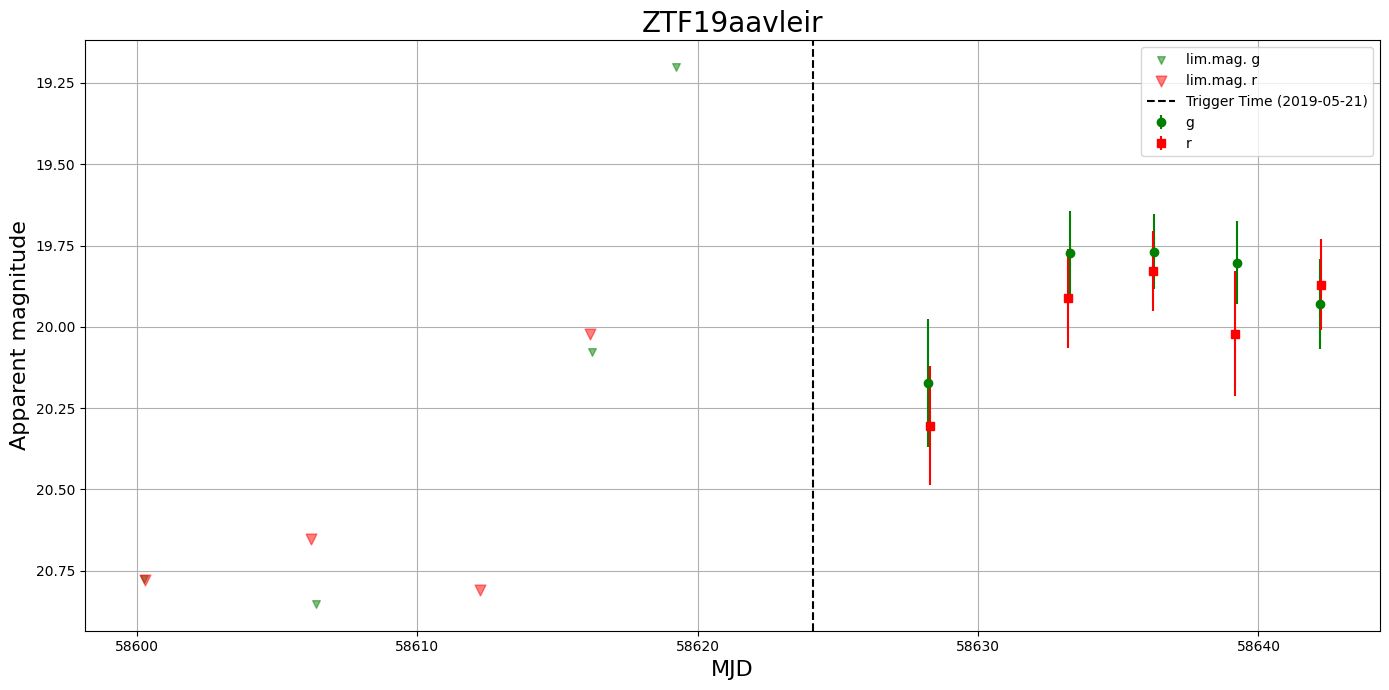

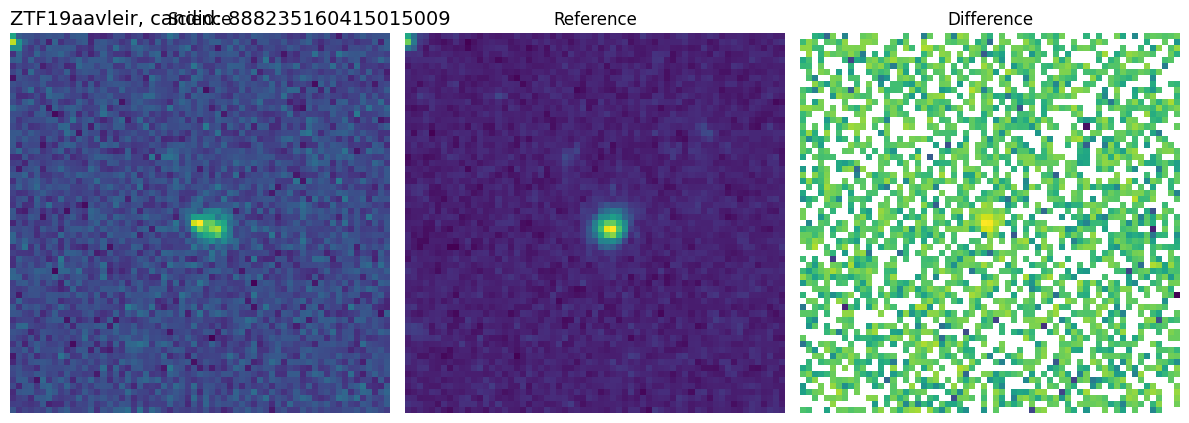

📈 Plotting light curve for ZTF19aavkzap


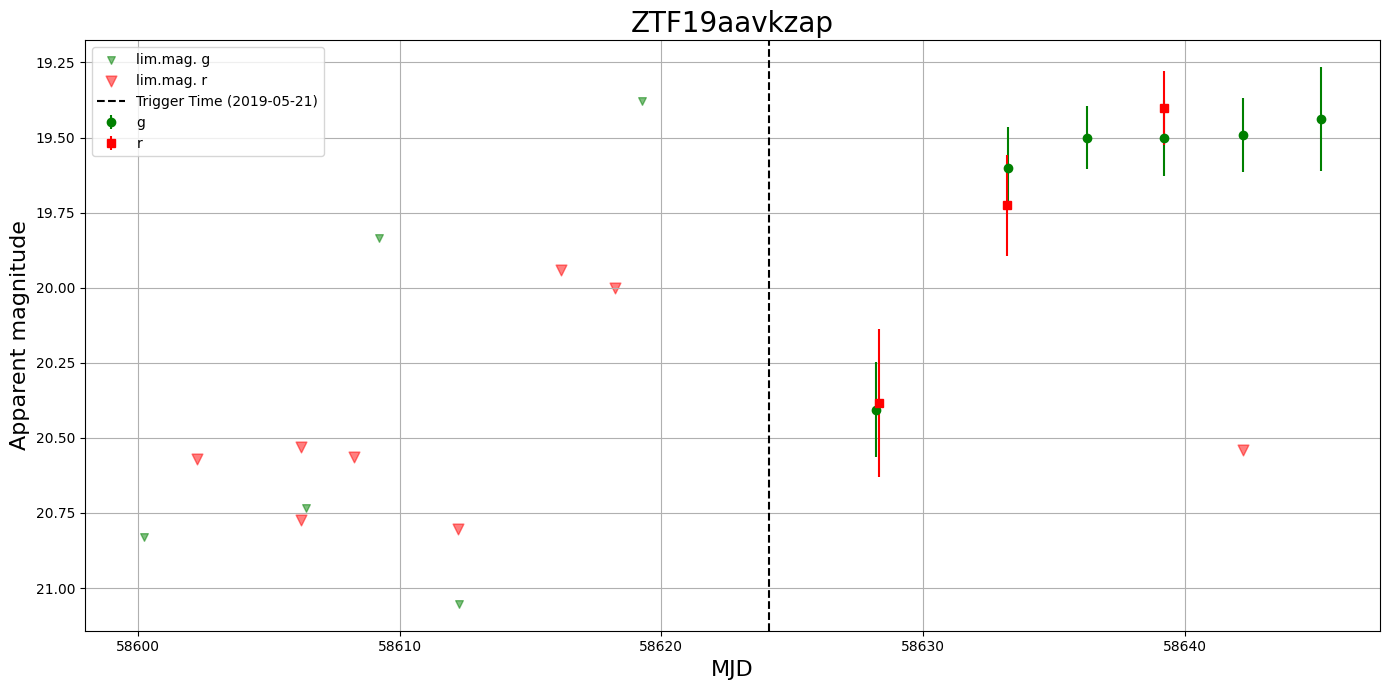

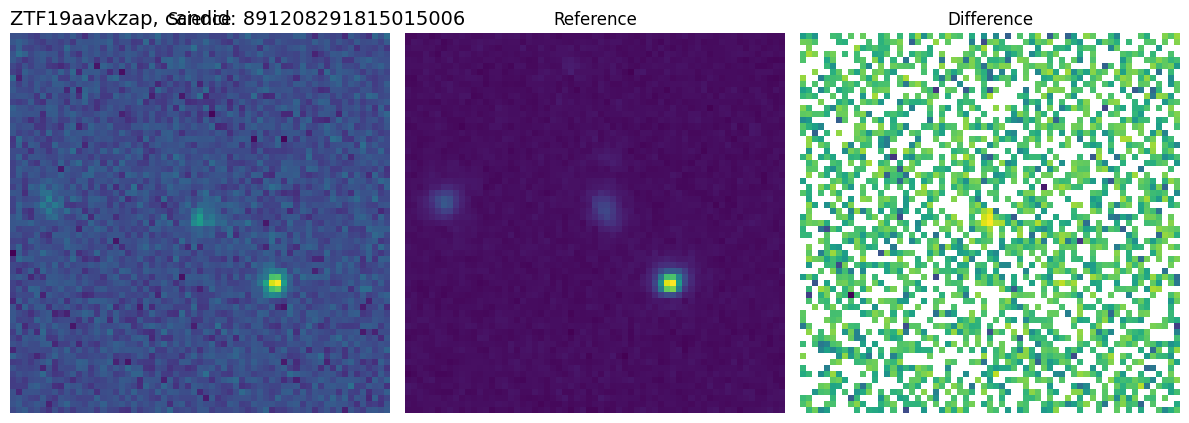

📈 Plotting light curve for ZTF19aavkxgt


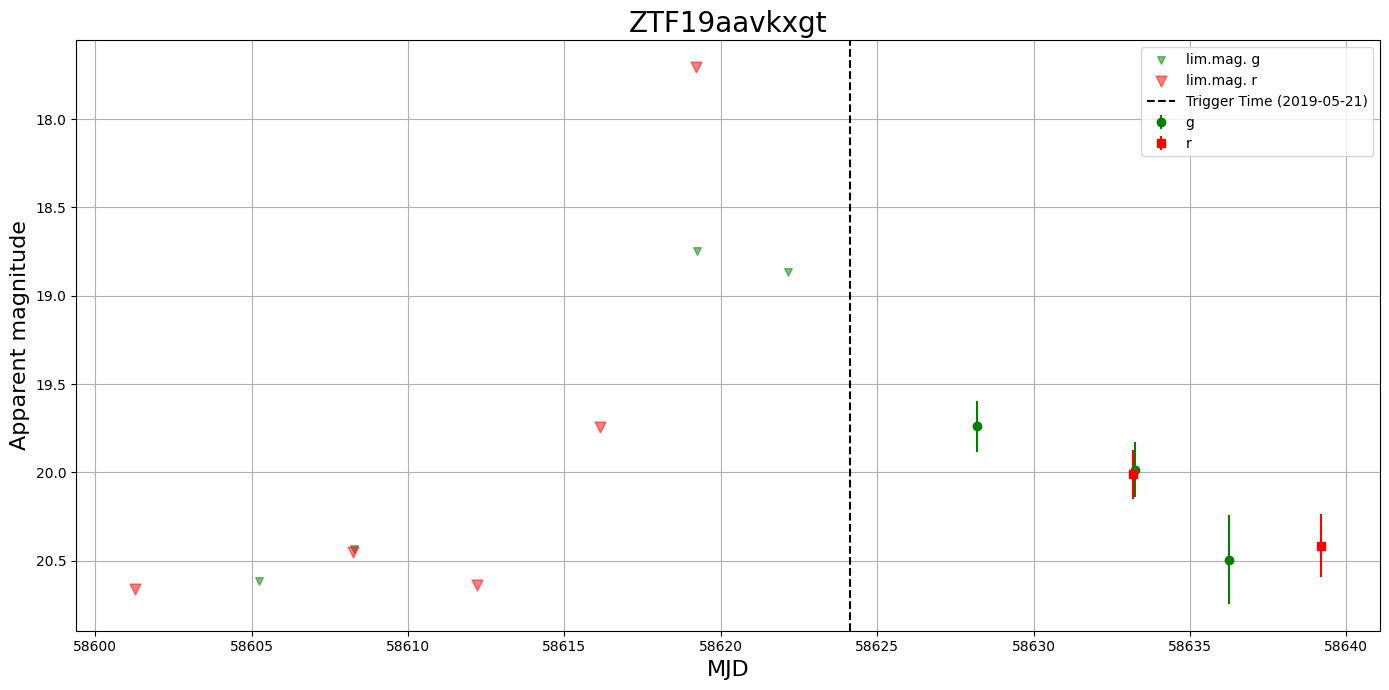

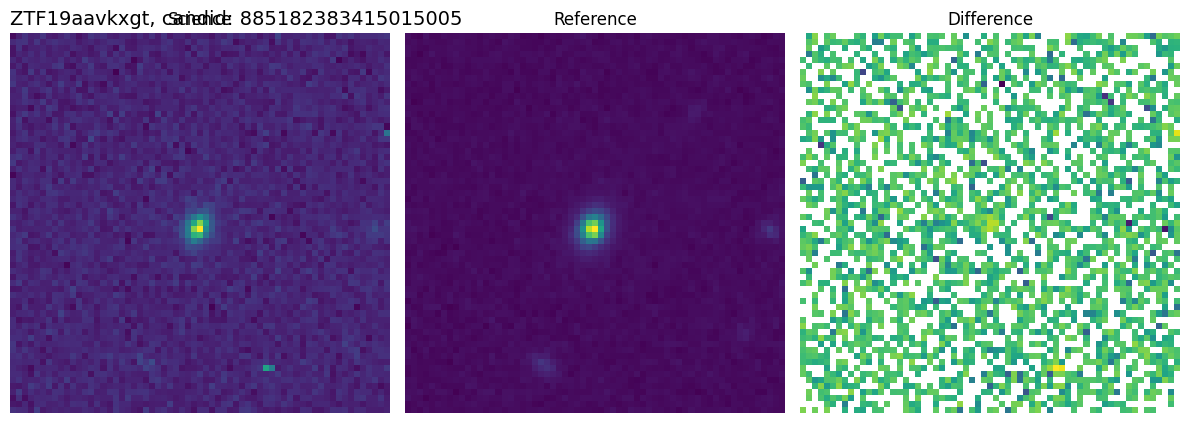

📈 Plotting light curve for ZTF19aavkyfd


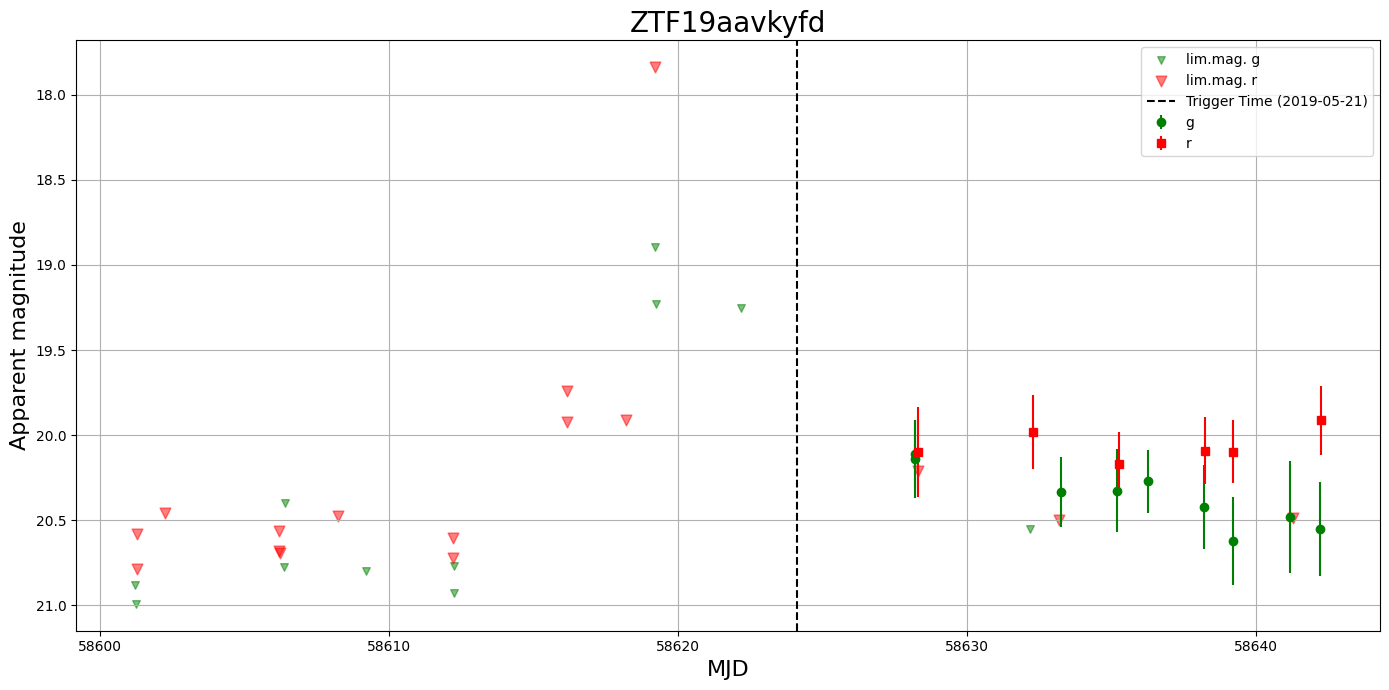

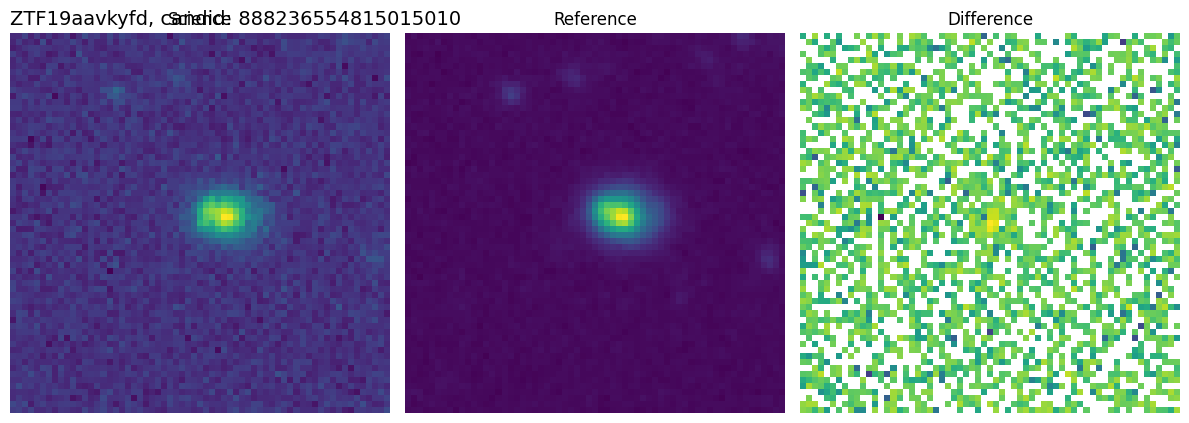

📈 Plotting light curve for ZTF19aavlpog


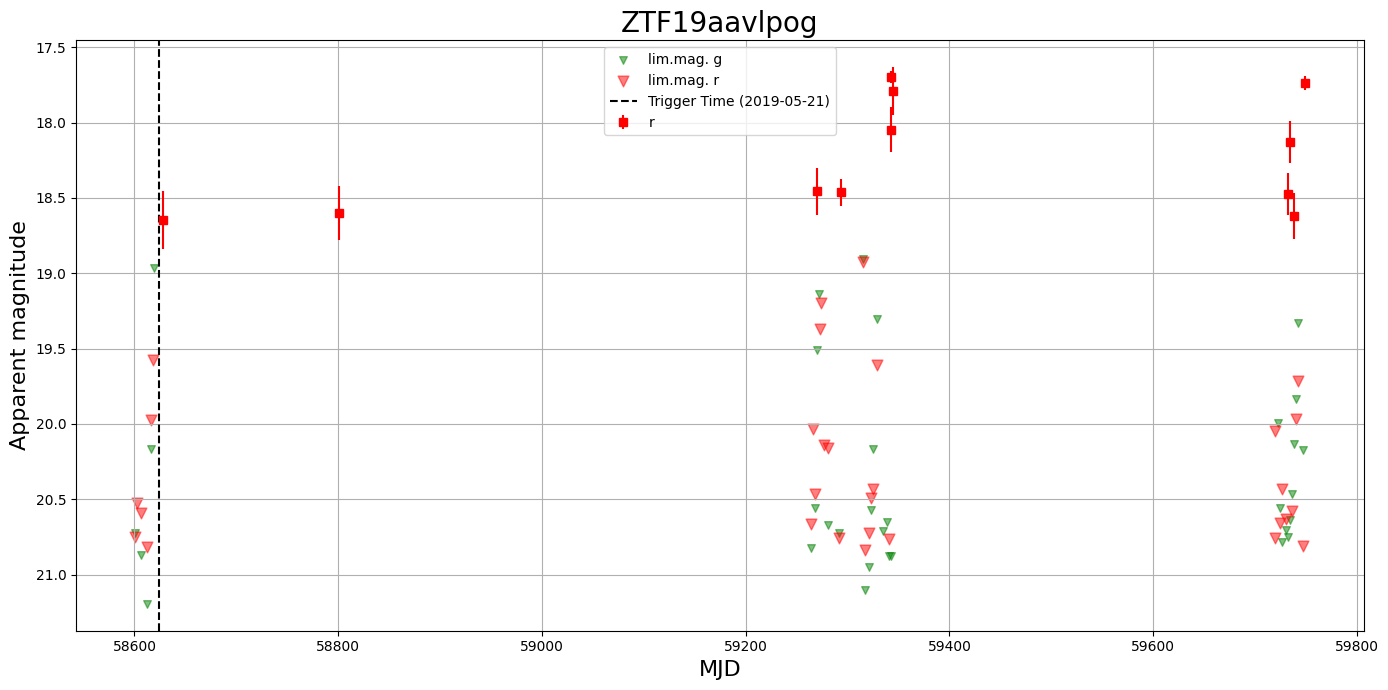

❌ Failed to fetch stamps for ZTF19aavlpog: Not a gzipped file (b'{"')
📈 Plotting light curve for ZTF19aavrqdg


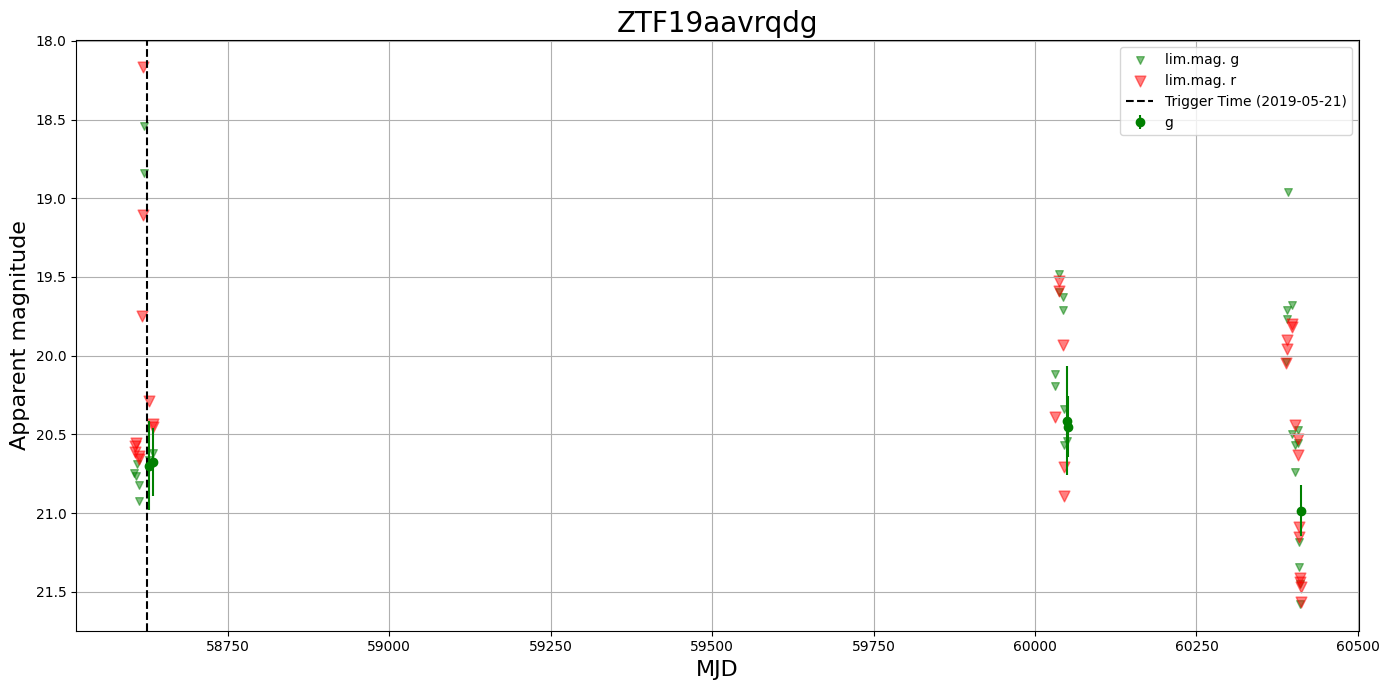

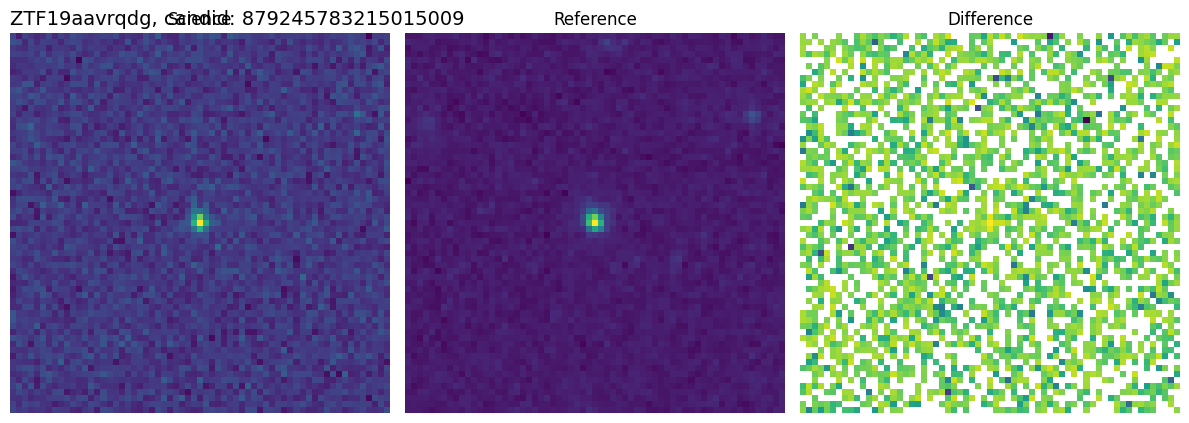

In [46]:
for oid in df_filtered["oid"].unique():
    print(f"Plotting light curve for {oid}")
    getSNdata(oid, doLC=True, doStamps = True)

As we see above, the transients identified span a wide variety of colors and timescales. In real-time filtering, one can apply additional filters such as evidence for a fast decaying light curve and red colors -- as expected of kilonovae. From visual vetting of the light curves, we see that all the events are long-lived (> 2 weeks), which would eventually rule all of them out in a search. 

Ultimately, this is a binary black hole merger event, so it is not suprising that we did not find a kilonova counterpart! 

**Now imagine the era of LSST, with the vastly large number of alerts (> 100X) per unit area on sky, is it still feasible to do untargeted searches like this? How do we narrow down to a feasible list of candidates?**

# Using external catalogs to aid discovery

Remember at the start of the notebook, we said that there was indeed a counterpart claimed for this event. As we will hear during the school, there are physically motivated models that suggest that BH-BH mergers inside AGN disks may indeed lead to electromagnetic counterparts. In this case, the timescales are likely longer due to the massive nature of the BHs. We can try to demonstrate such a search together with the utility of external catalogs in such searches. 

Let's start by repeating the Alerce query -- this time with a longer time window extending an additional 1 month beyond our original search. 

In [60]:
# Revised MJD range with an additional 30 days
start_time = Time('2019-05-21 03:02:29', format='iso', scale='utc').mjd
end_time = Time('2019-06-26 03:02:29', format='iso', scale='utc').mjd

print(f"Start MJD: {start_time}, End MJD: {end_time}")

#Lets query Alerce!
df = client.query_objects(
    format='pandas',
    ra=center.ra.degree,
    dec=center.dec.degree,
    radius=max_radius * 3600,  # in arcsec
    firstmjd=[start_time, end_time],
    page_size=10000,
    ndet = [3, 99999]
)

print(f"Found {len(df)} objects")

#repeat filtering for old objects
df_filtered = df[(df["mjdstarthist"] > start_time) & (df["mjdstarthist"] < end_time)]
print(len(df_filtered))

Start MJD: 58624.12672453704, End MJD: 58660.12672453704
Found 784 objects
155


Because our model predictions suggest that such objects should be in AGN disks, we can further cut down by crossmatching to an external catalog, such as the [Milliquas](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E..49F/abstract) catalog on Vizier. One could also do a similar query say to crossmatch cnadidates against a catalog of galaxies if relevant. To demonstrate, let's crossmatch our sources to this catalog on Vizier.

In [64]:
from astroquery.vizier import Vizier

catalog = "VII/294" #Milliquas catalog ID
radius = 2 * u.arcsec
agn_oids = []
agn_zs = []
for index, row in df_filtered.iterrows():
    ra = row['meanra']
    dec = row['meandec']
    oid = row['oid']

    coord = SkyCoord(
        ra=ra*u.deg,
        dec=dec*u.deg,
        frame='icrs'
    )

    result = Vizier.query_region(coord, radius=radius, catalog=catalog)
    if result:
        agn_name = result[0]['Name'].value[0]
        z = result[0]['z'].value[0]
        print(f"Source {oid} crossmatched to AGN {agn_name} at redshift {z}") 

        agn_oids.append(oid)
        agn_zs.append(z)

Source ZTF19abcgjqe crossmatched to AGN LAMOSTJ134005.01+352934.7 at redshift 1.215999960899353
Source ZTF19aaydtdo crossmatched to AGN PGC 140177 at redshift 0.0729999989271164
Source ZTF18aasvemn crossmatched to AGN 1WGA J1222.6+2934 at redshift 0.7860000133514404
Source ZTF19aavrpbd crossmatched to AGN SDSS J114410.06+321506.9 at redshift 2.2839999198913574
Source ZTF19aavqgib crossmatched to AGN SDSS J132759.35+250429.7 at redshift 0.38100001215934753
Source ZTF19aaydsvw crossmatched to AGN FBQS J13461+2540 at redshift 0.38999998569488525
Source ZTF19aavyqor crossmatched to AGN SDSS J120659.38+410514.6 at redshift 1.3760000467300415
Source ZTF19aawuqrb crossmatched to AGN Gaia 4026651446249368064 at redshift 0.36000001430511475
Source ZTF19abanrhr crossmatched to AGN SDSS J124942.30+344928.9 at redshift 0.43799999356269836
Source ZTF19aavrpbz crossmatched to AGN SDSS J120132.12+372911.7 at redshift 1.0119999647140503
Source ZTF19aawoffr crossmatched to AGN SDSS J121739.80+375240.6 

And there we go, we were able to narrow down to < 20 objects using an external catalog crossmatch. A key advantage of assuming such an association between the transient and external catalog is that we can draw on the information in the external catalog (e.g. redshift) to apply additional physically motivated filters. 

While we haven't used this yet, let's take a look at the distance information available in the GW map and overlay the likely distances of the candidate counterparts. 

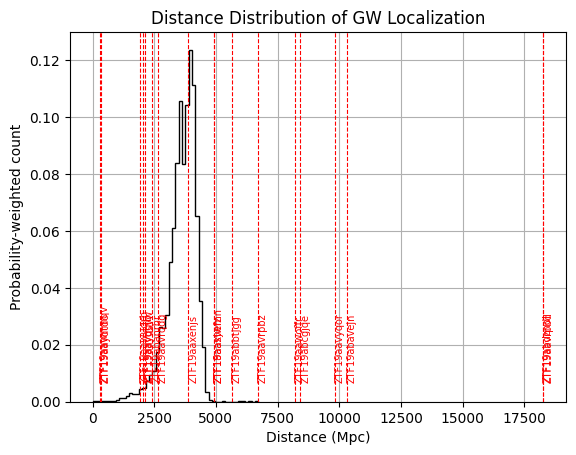

In [70]:
# Filter out non-finite or zero probabilities
valid = (prob > 0) & np.isfinite(distmu) & np.isfinite(distsigma) & (distmu > 0)

from astropy.cosmology import FlatLambdaCDM

# Convert redshift to luminosity distance
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
agn_dists = cosmo.luminosity_distance(agn_zs).value  # in Mpc

# Create weighted histogram of distances using distmu, weighted by prob
plt.hist(distmu[valid], weights=prob[valid], bins=50, histtype='step', color='black')

# Add vertical lines and labels
for oid, dist in zip(agn_oids, agn_dists):
    plt.axvline(dist, color='red', linestyle='--', linewidth=0.8)
    plt.text(dist, plt.ylim()[1]*0.05, oid, rotation=90, verticalalignment='bottom', fontsize=7, color='red')

plt.xlabel('Distance (Mpc)')
plt.ylabel('Probability-weighted count')
plt.title('Distance Distribution of GW Localization')
plt.grid(True)
plt.show()

Here we see that most of the candidates identified with a pure 2D spatial search are in fact outside the 3D localization volume! We can use this information to further filter for candidates that have luminosity distances between about 2 - 5 Gpc (see map above)


In [72]:
from astropy.cosmology import z_at_value

lim_low_z = z_at_value(cosmo.luminosity_distance, 2 * u.Gpc)
lim_high_z = z_at_value(cosmo.luminosity_distance, 5 * u.Gpc)

final_agn_cands = []
for i in range(len(agn_oids)):
    if agn_zs[i] > lim_low_z and agn_zs[i] < lim_high_z:
        final_agn_cands.append(agn_oids[i])

print('Remaining %d candidates in crossmatch'%len(final_agn_cands))

Remaining 7 candidates in crossmatch


We are left with just 7 sources! At this stage, the number is small enough that we can repeat our visual vetting process.

 Plotting light curve for ZTF18aasvemn


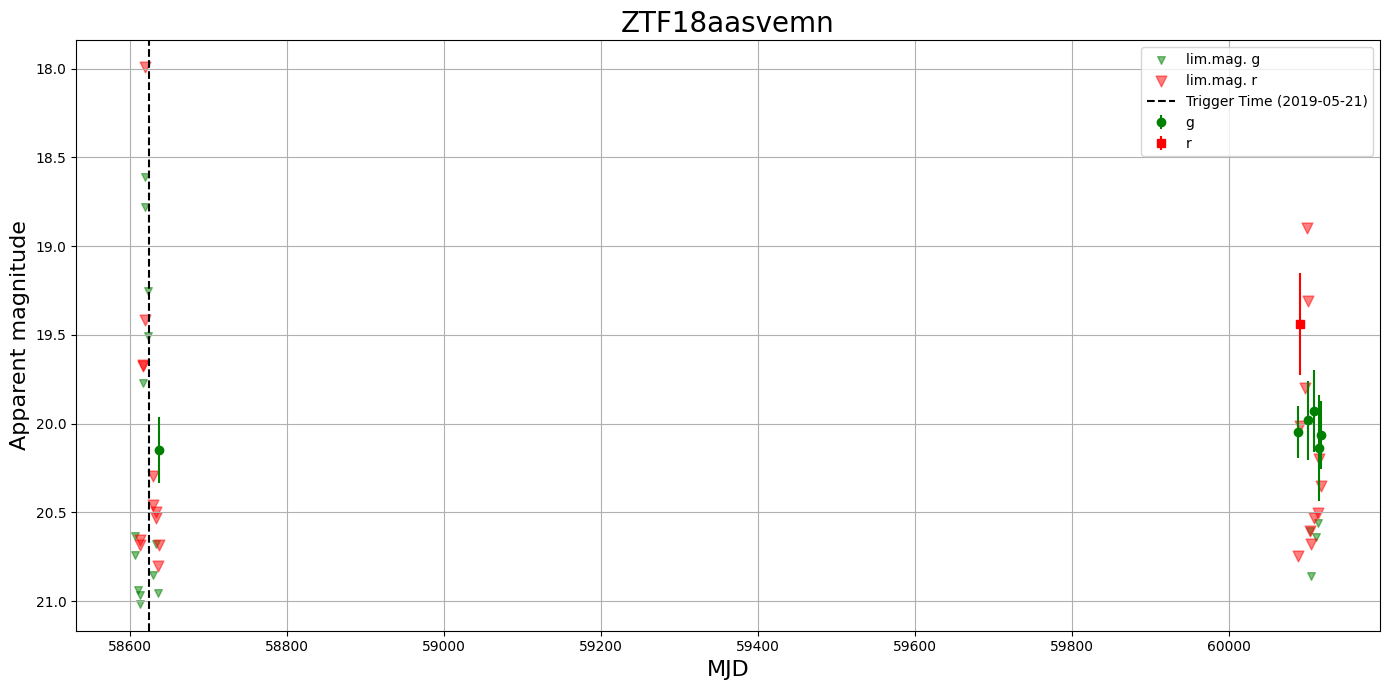

/var/folders/nz/hcm2rh5x19q0p928d8hqzzj00000gn/T/ipykernel_30772/2212437948.py:27: RuntimeWarning: invalid value encountered in log1p
  img = np.log1p(images[i])  # log scale with log1p for stability


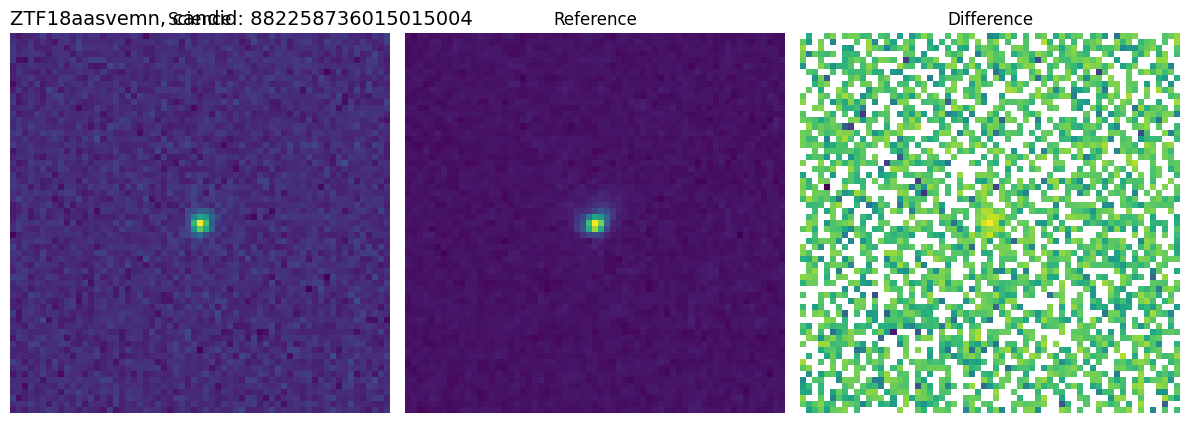

 Plotting light curve for ZTF19aavqgib


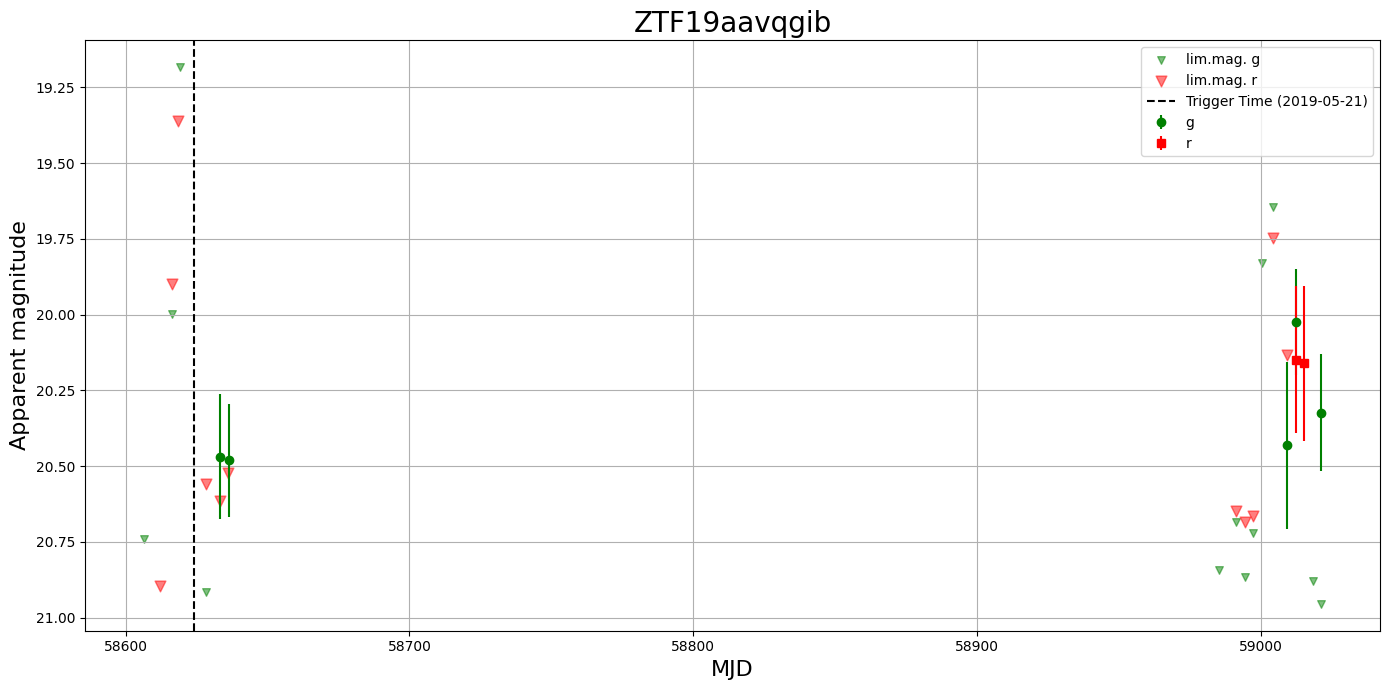

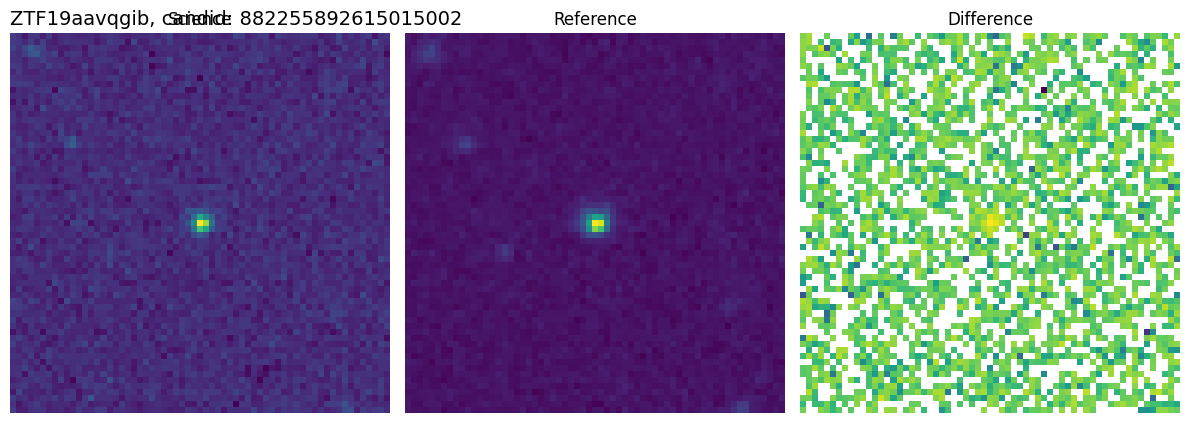

 Plotting light curve for ZTF19aaydsvw


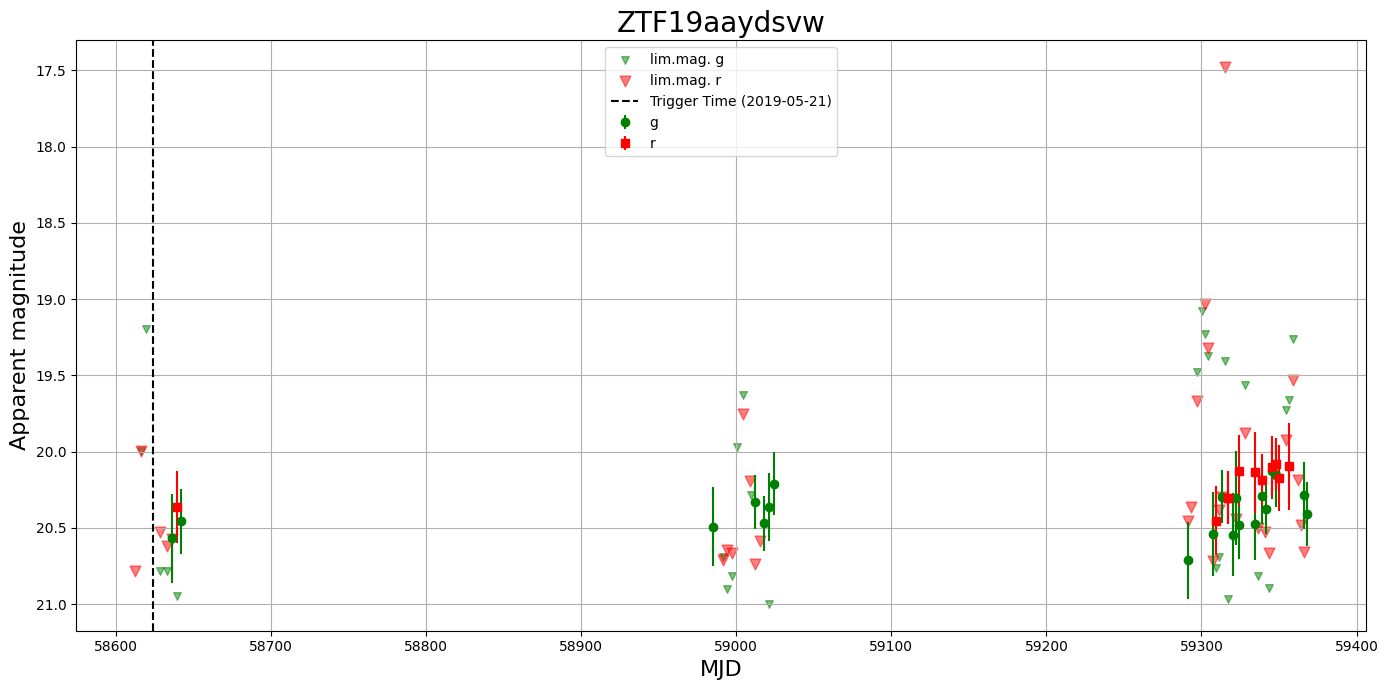

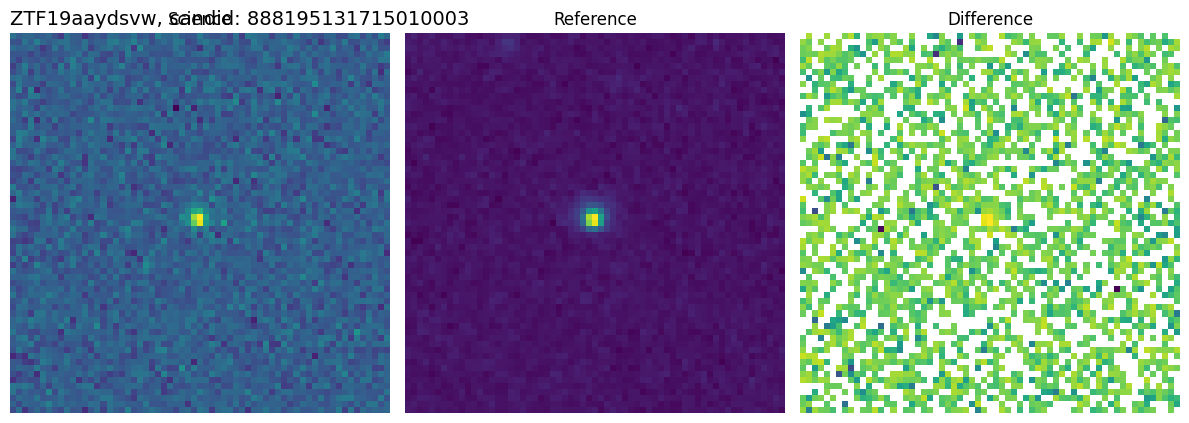

 Plotting light curve for ZTF19abanrhr


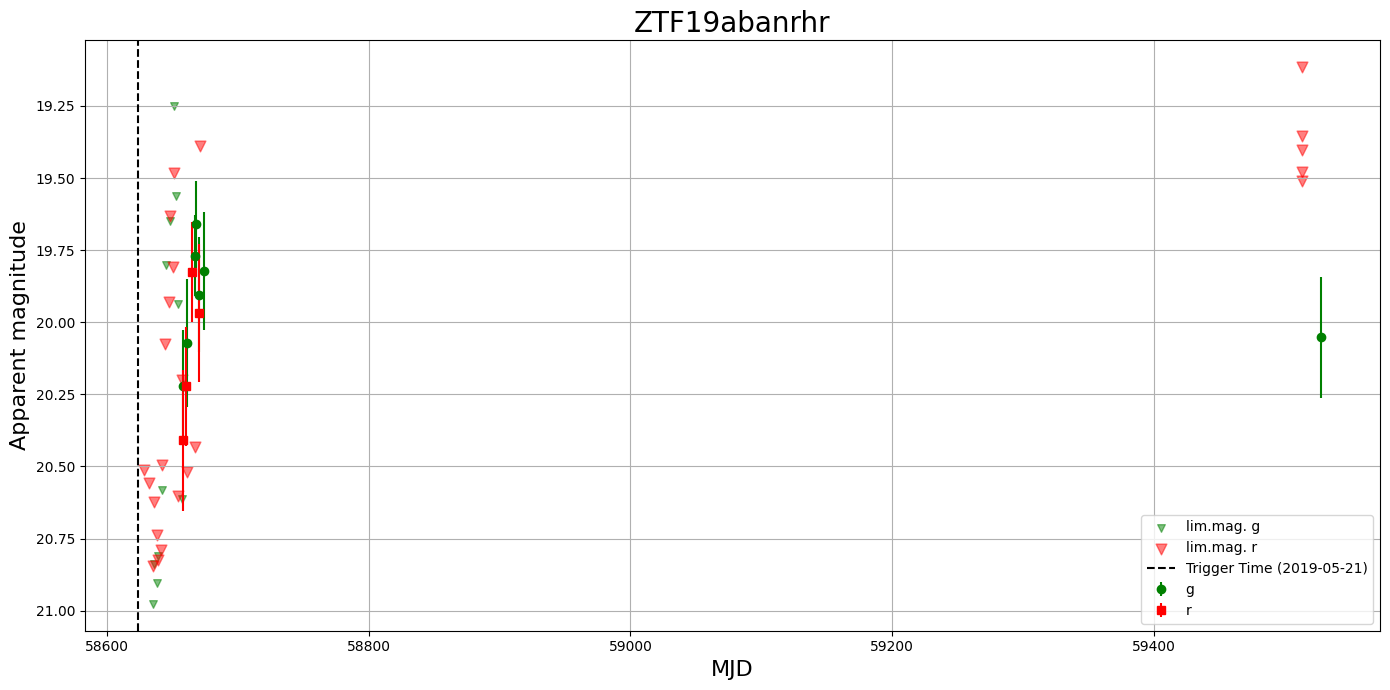

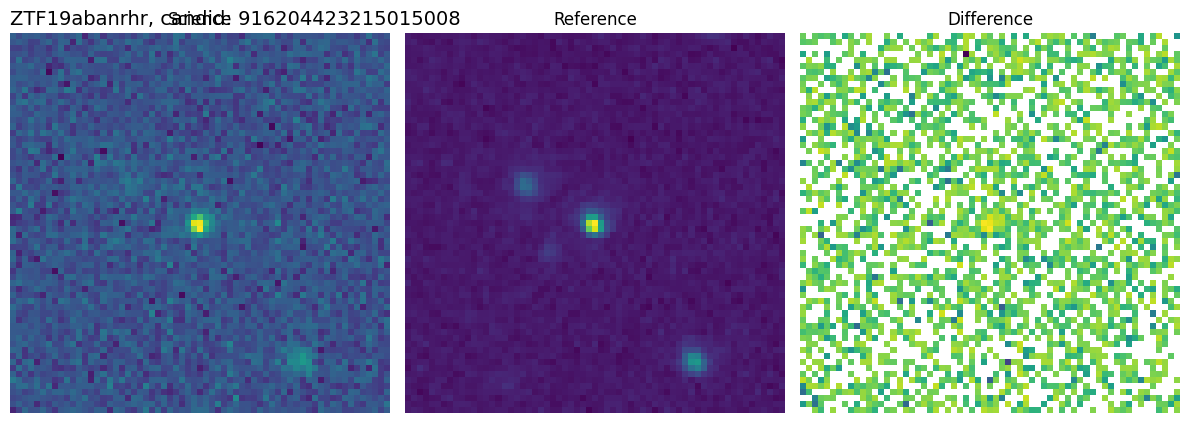

 Plotting light curve for ZTF19aaxenjs


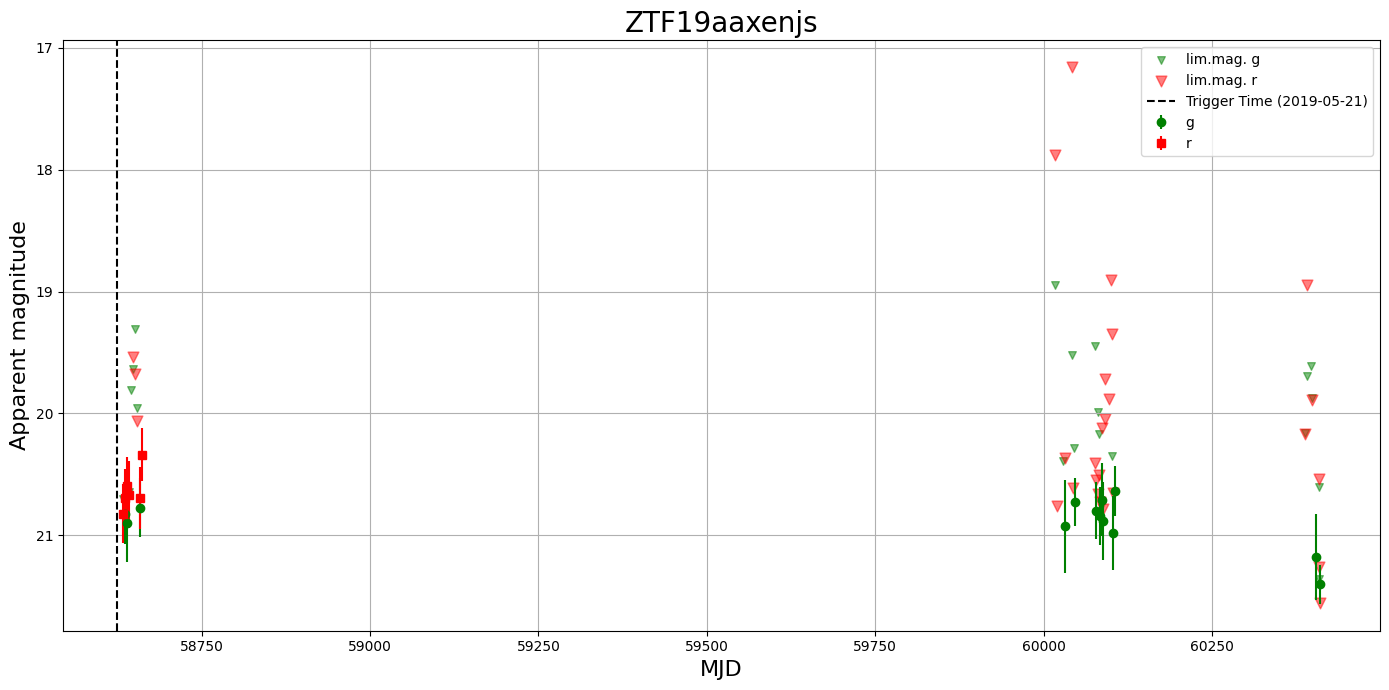

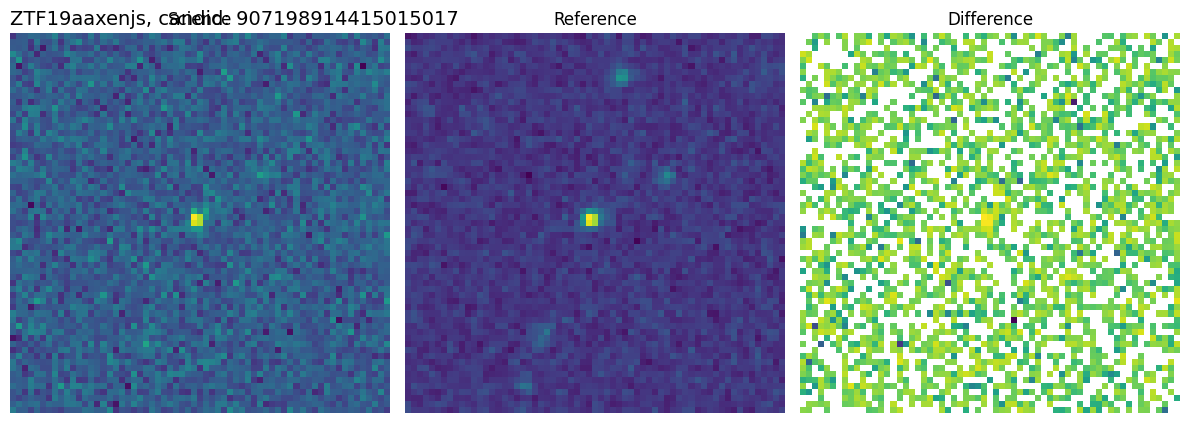

 Plotting light curve for ZTF19aaxjwfz


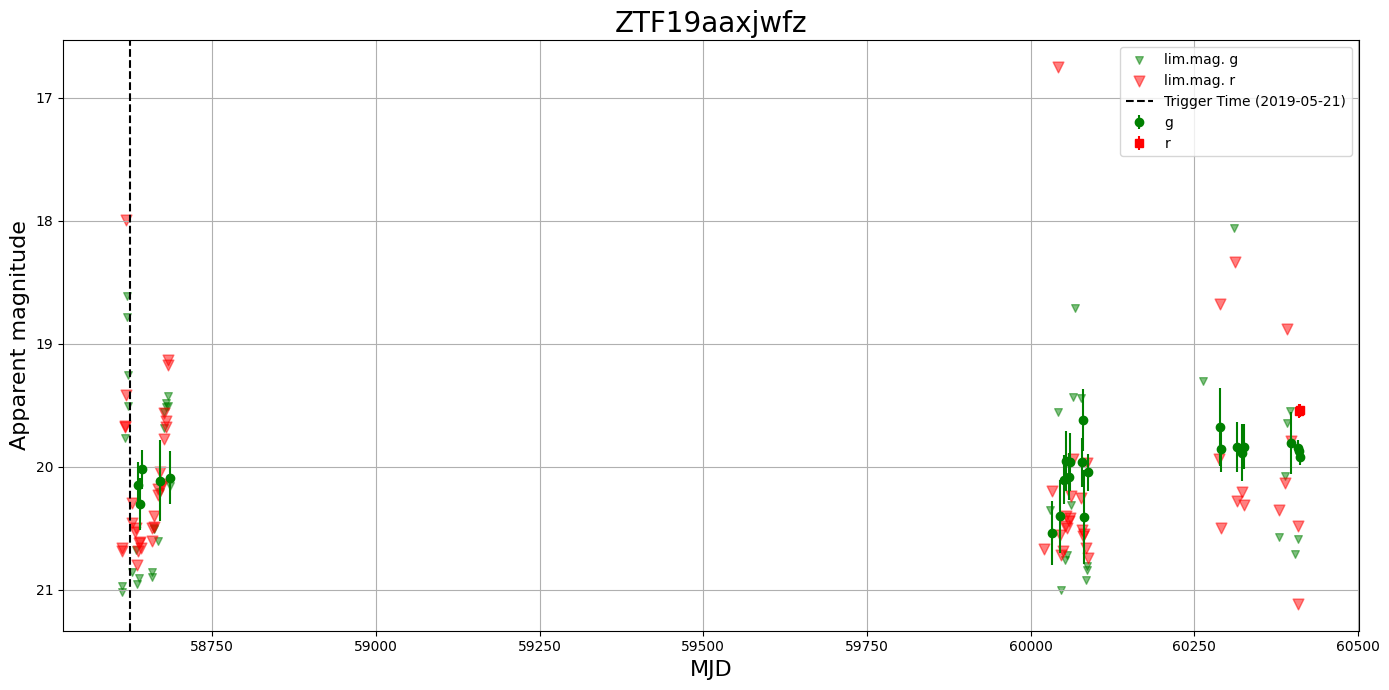

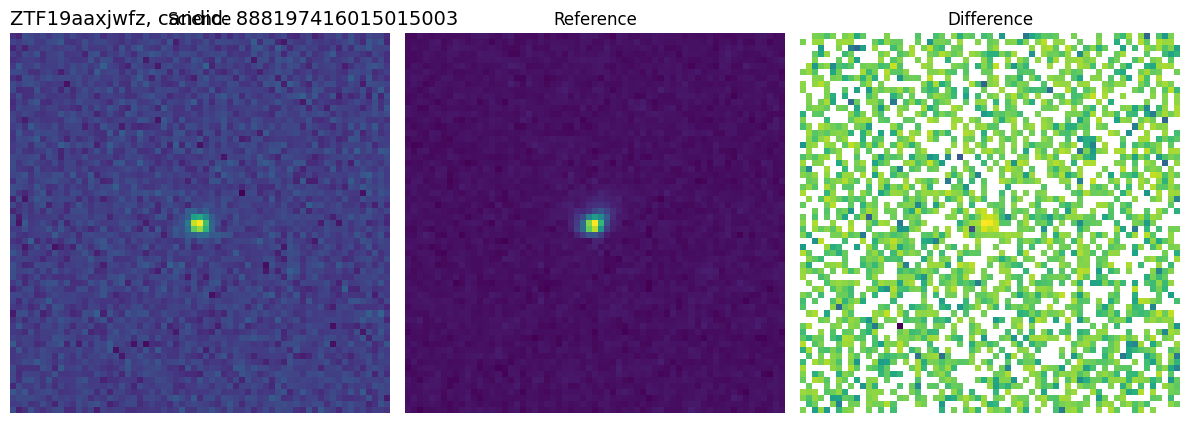

 Plotting light curve for ZTF19aavrqdg


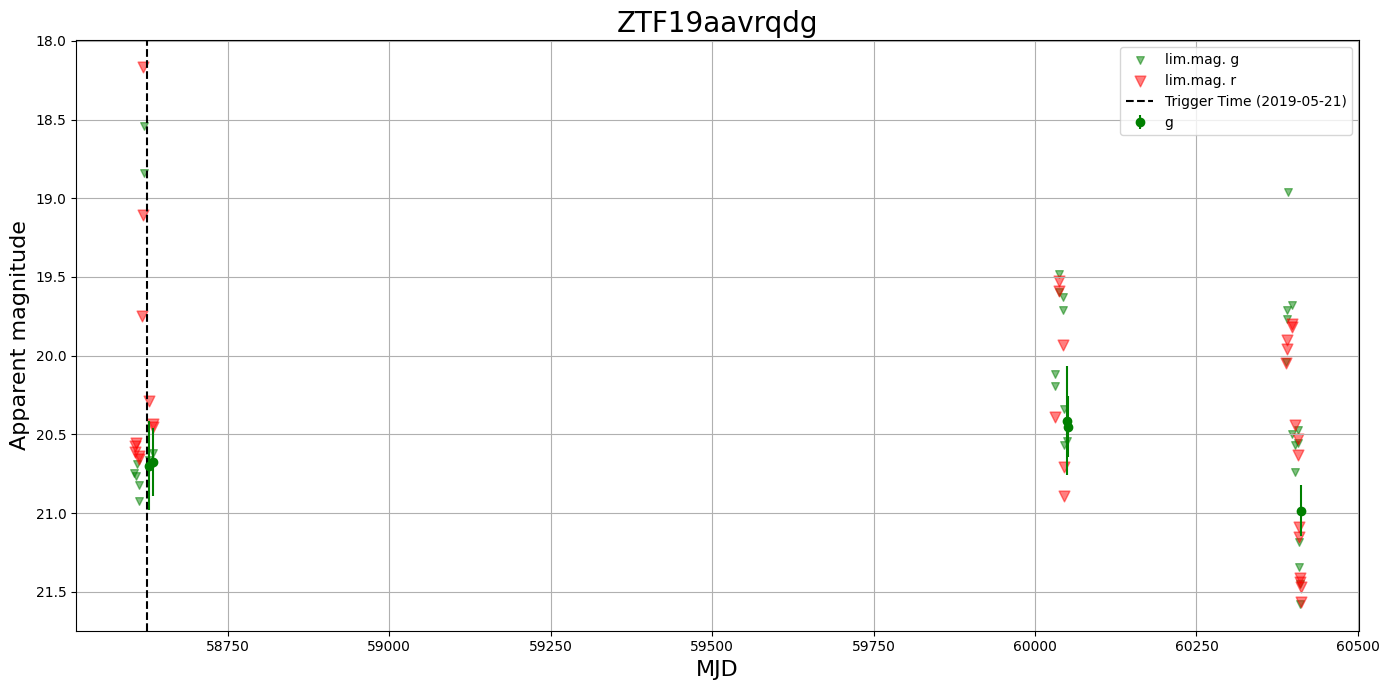

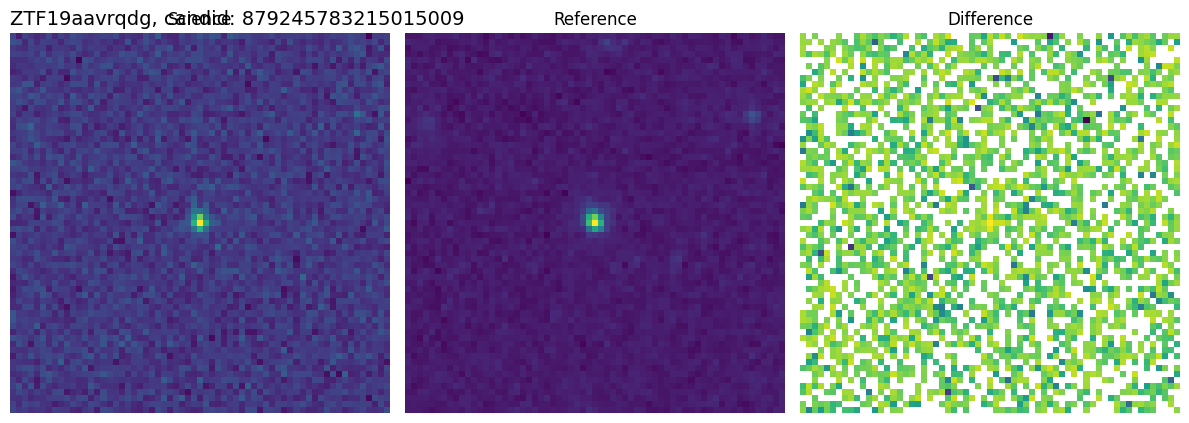

In [73]:
for oid in final_agn_cands:
    print(f" Plotting light curve for {oid}")
    getSNdata(oid, doLC=True, doStamps = True)

Remember again that here we have the luxury of "knowing" the future evolution of all the sources since the time of the trigger. Visually inspect these light curves, does any one stand out? 

We expect even BBH mergers in AGN disks to be catastrophic events (or possibly extremely long recurrence times; see [Graham et al. 2021](https://ui.adsabs.harvard.edu/abs/2020PhRvL.124y1102G/abstract)), implying that the transient should be a one-time appearance instead of the general burbling that AGN are known to do otherwise. 

Upon careful inspection, one sees that the source **ZTF19abanrhr** is distinctive in this population in having showed a single flare around the time of the event, while others have exhibited continuous variability. This is in fact the candidate laimed by [Graham et al. 2021](https://ui.adsabs.harvard.edu/abs/2020PhRvL.124y1102G/abstract). **We have just re-discovered it using few lines of code!** For interested readers, it will be worth going through that paper to understand the use the additional archival information from prior time domain surveys that further supported an association. 

The use of three dimensional information as well as external catalogs helps us dramatically reduce the number of plausible candidates -- and particularly powerful in the era of massively multiplexed spectroscopic surverys. This is **going to be critical in the era of LSST** where the substantially larger depth will produce $> 200$ times more transients per unit area on the sky.

# Subject for discussion: Broader ideas on how to filter for associations? 